In [ ]:
your_path = "/content/drive/My Drive/Lectures/multicampus/nlp_2021_dec/day2/practice"
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(your_path)
    print(os.getcwd())
except ModuleNotFoundError:
    print("you are not in google colab, pass this phase")

Mounted at /content/drive
/content/drive/My Drive/Lectures/multicampus/nlp_2021_dec/day2/practice


# Package

In [ ]:
# vocab 사용을 위한 sentencepiece 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [ ]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import numpy as np
import pandas as pd
import random
import collections
import json
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
# gpu 확인
!nvidia-smi

Wed Dec 22 18:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# Transformer Tutorial

## Config

In [ ]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
# config 생성
# d_model: model hidden dim
# n_head: multi head attention head number
# d_head: multi head attention head dim
# dropout: dropout rate
# d_ff: feed forward dim
# layernorm_epsilon: layernormal epsilon
# n_layer: layer number
# n_seq: sequence max number
# n_vocab: vocab count
# i_pad: vocab pad id
config = Config({"d_model": 8, "n_head": 2, "d_head": 4, "dropout": 0.1, "d_ff": 32, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 10, "n_vocab": 0, "i_pad": 0})
config.n_vocab = 10
config.i_pad = 0
config

{'d_ff': 32,
 'd_head': 4,
 'd_model': 8,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 2,
 'n_layer': 3,
 'n_seq': 10,
 'n_vocab': 10}

## Inputs

In [ ]:
# encoder 입력 값 정의
enc_tokens = np.random.randint(1, config.n_vocab, (1, 6))
# 마지막은 padding
enc_tokens[:,5:] = config.i_pad
enc_tokens

array([[4, 7, 6, 5, 9, 0]])

In [ ]:
# 입력 값 정의
dec_tokens = np.random.randint(1, config.n_vocab, (1, 5))
# 마지막은 padding
dec_tokens[:,4:] = config.i_pad
dec_tokens

array([[8, 7, 9, 1, 0]])

## Weight Shared Embedding

![](https://paul-hyun.github.io/assets/transformer/weight_shared_embedding.png)

### Embedding Tutorial

In [ ]:
# embedding weight 초기화
embed_weight = tf.random.normal([config.n_vocab, config.d_model])
embed_weight

<tf.Tensor: shape=(10, 8), dtype=float32, numpy=
array([[ 0.8369314 , -0.73429775,  1.0402943 ,  0.04035992, -0.7218659 ,
         1.0794858 ,  0.9032698 , -0.73601735],
       [-0.36105633, -0.6078763 ,  0.07614239, -0.7211218 ,  0.14663379,
         1.0210938 , -0.17570543,  1.2770809 ],
       [ 0.15558745,  0.11838357, -0.10230648,  0.02042525,  0.12023098,
        -1.7356888 , -0.37274906, -0.8804749 ],
       [ 0.8006071 , -1.0832181 , -0.8637153 ,  0.13195874,  0.44462258,
         1.1913583 ,  1.5747397 , -0.57046455],
       [ 1.4189912 ,  0.5309418 , -0.3397897 , -0.5185629 , -1.1675295 ,
         0.77573264, -1.5179933 ,  0.73918307],
       [ 1.8952272 , -0.20591696, -0.72119623, -1.1176348 ,  0.85716414,
        -0.37806422, -0.121459  ,  0.00689717],
       [ 1.2772721 ,  0.3844953 ,  0.18691574,  1.2595506 , -0.15900195,
         0.12100661, -0.42040455,  2.4253113 ],
       [-0.3567563 , -0.61342746,  1.3244288 , -0.5528212 ,  1.2431467 ,
        -0.24536318,  0.2899293

In [ ]:
# embedding lookup 대신에 tf.gather 함수 사용
token_embed1 = tf.gather(embed_weight, enc_tokens)
token_embed1

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 1.4189912 ,  0.5309418 , -0.3397897 , -0.5185629 ,
         -1.1675295 ,  0.77573264, -1.5179933 ,  0.73918307],
        [-0.3567563 , -0.61342746,  1.3244288 , -0.5528212 ,
          1.2431467 , -0.24536318,  0.28992936, -0.25124574],
        [ 1.2772721 ,  0.3844953 ,  0.18691574,  1.2595506 ,
         -0.15900195,  0.12100661, -0.42040455,  2.4253113 ],
        [ 1.8952272 , -0.20591696, -0.72119623, -1.1176348 ,
          0.85716414, -0.37806422, -0.121459  ,  0.00689717],
        [ 0.18089716, -0.19718426, -0.24024896,  0.8510773 ,
          1.5659982 , -1.1252568 , -1.9409477 ,  1.5495228 ],
        [ 0.8369314 , -0.73429775,  1.0402943 ,  0.04035992,
         -0.7218659 ,  1.0794858 ,  0.9032698 , -0.73601735]]],
      dtype=float32)>

In [ ]:
# embedding 값에 d_model ** 0.5 곱
token_embed = token_embed1 * config.d_model ** 0.5
token_embed

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 4.013513  ,  1.5017301 , -0.96107036, -1.4667174 ,
         -3.3022718 ,  2.1941032 , -4.2935333 ,  2.0907254 ],
        [-1.0090592 , -1.7350348 ,  3.7460504 , -1.5636145 ,
          3.5161498 , -0.69399184,  0.82004404, -0.71063024],
        [ 3.612671  ,  1.0875169 ,  0.5286775 ,  3.562547  ,
         -0.44972542,  0.34225836, -1.1890836 ,  6.859816  ],
        [ 5.360512  , -0.58242106, -2.039851  , -3.1611485 ,
          2.4244263 , -1.0693271 , -0.34353793,  0.01950813],
        [ 0.51165444, -0.5577213 , -0.6795267 ,  2.40721   ,
          4.4293118 , -3.1827068 , -5.489829  ,  4.382712  ],
        [ 2.3671994 , -2.0769076 ,  2.9423966 ,  0.11415508,
         -2.041745  ,  3.0532467 ,  2.554833  , -2.0817714 ]]],
      dtype=float32)>

### Linear Tutorial

In [ ]:
# linear layer
# (n_batch, n_seq, d_model) -> (n_batch * n_seq, d_model)
n_batch, n_seq, d_model = tf.shape(token_embed)
token_reshape = tf.reshape(token_embed, [-1, d_model])
token_reshape

<tf.Tensor: shape=(6, 8), dtype=float32, numpy=
array([[ 4.013513  ,  1.5017301 , -0.96107036, -1.4667174 , -3.3022718 ,
         2.1941032 , -4.2935333 ,  2.0907254 ],
       [-1.0090592 , -1.7350348 ,  3.7460504 , -1.5636145 ,  3.5161498 ,
        -0.69399184,  0.82004404, -0.71063024],
       [ 3.612671  ,  1.0875169 ,  0.5286775 ,  3.562547  , -0.44972542,
         0.34225836, -1.1890836 ,  6.859816  ],
       [ 5.360512  , -0.58242106, -2.039851  , -3.1611485 ,  2.4244263 ,
        -1.0693271 , -0.34353793,  0.01950813],
       [ 0.51165444, -0.5577213 , -0.6795267 ,  2.40721   ,  4.4293118 ,
        -3.1827068 , -5.489829  ,  4.382712  ],
       [ 2.3671994 , -2.0769076 ,  2.9423966 ,  0.11415508, -2.041745  ,
         3.0532467 ,  2.554833  , -2.0817714 ]], dtype=float32)>

In [ ]:
# matrix mul with embd_weight
token_linear = tf.matmul(token_reshape, embed_weight, transpose_b=True)
token_reshape.shape, embed_weight.shape, token_linear

(TensorShape([6, 8]),
 TensorShape([10, 8]),
 <tf.Tensor: shape=(6, 10), dtype=float32, numpy=
 array([[  0.5325971 ,   3.8031163 ,  -3.5751386 ,  -4.5850925 ,
          21.20014   ,   6.50547   ,  11.342962  ,  -9.228753  ,
          -6.7945375 ,   3.3453908 ],
        [  2.2398205 ,   1.5871407 ,   1.1697465 ,   0.06301939,
          -9.228753  ,   0.66257733,  -5.936514  ,  12.20775   ,
          -3.2334604 ,   1.5232469 ],
        [ -2.5101418 ,   4.7587724 ,  -5.535282  ,  -3.8501904 ,
          11.342961  ,   1.9368417 ,  26.868544  ,  -5.936514  ,
          -9.599032  ,  15.192061  ],
        [ -0.56467783,  -0.1082584 ,   3.1675892 ,   5.5191536 ,
           6.5054693 ,  17.807726  ,   1.9368415 ,   0.6625773 ,
          -8.315366  ,   4.581168  ],
        [-14.589604  ,   2.327972  ,   4.3764596 , -11.049268  ,
           3.345391  ,   4.581168  ,  15.192061  ,   1.523247  ,
          -8.76939   ,  30.378746  ],
        [ 15.181544  ,   0.26030624,  -4.840591  ,   9.559091  ,


In [ ]:
# (bs * n_seq, n_vocab) -> (bs, n_seq, n_vocab)
output = tf.reshape(token_linear, [n_batch, n_seq, config.n_vocab])
output.shape

TensorShape([1, 6, 10])

### Class

In [ ]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

### Test

In [ ]:
# SharedEmbedding embedding test: shape이 (bs, n_seq, d_model)이면 성공
embedding = SharedEmbedding(config)

enc_embed = embedding(enc_tokens)
assert enc_embed.shape == (enc_tokens.shape[0], enc_tokens.shape[1], config.d_model)
enc_embed

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 1.0438616 ,  0.77873224,  0.3661703 ,  0.04562705,
         -1.1118658 ,  0.83142024, -0.50751346, -1.6061306 ],
        [-1.488764  ,  0.66749793,  0.45289573, -1.3284956 ,
         -0.8350257 , -0.14791092,  0.46348926,  0.68240696],
        [ 0.53093785,  1.8387237 , -1.4564208 , -0.22360843,
          0.8672876 , -0.75745213,  1.4629304 , -1.8092779 ],
        [-0.13200705,  0.9998998 , -0.9900697 , -0.2264822 ,
          0.5969744 , -0.13854134,  1.1348592 , -0.04831744],
        [-1.3377118 ,  1.3356653 , -0.26913092, -1.4376115 ,
         -0.3685191 ,  1.0541942 ,  0.37812105, -0.32949397],
        [ 1.1468067 ,  0.9645993 ,  0.87830144, -0.31010216,
         -0.4058371 , -0.04709157, -0.32690668,  0.5287341 ]]],
      dtype=float32)>

In [ ]:
# SharedEmbedding embedding test: shape이 (bs, n_seq, d_model)이면 성공
dec_embed = embedding(dec_tokens)
assert dec_embed.shape == (dec_tokens.shape[0], dec_tokens.shape[1], config.d_model)
dec_embed

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 1.7347238 , -0.40107146,  1.5544791 ,  0.83802575,
         -0.6956781 , -0.06145862,  1.496493  , -1.8350446 ],
        [-1.488764  ,  0.66749793,  0.45289573, -1.3284956 ,
         -0.8350257 , -0.14791092,  0.46348926,  0.68240696],
        [-1.3377118 ,  1.3356653 , -0.26913092, -1.4376115 ,
         -0.3685191 ,  1.0541942 ,  0.37812105, -0.32949397],
        [ 0.47501525, -0.7355799 ,  0.66509944, -0.3943125 ,
          0.71738523, -0.24470258, -0.27618337,  0.6821183 ],
        [ 1.1468067 ,  0.9645993 ,  0.87830144, -0.31010216,
         -0.4058371 , -0.04709157, -0.32690668,  0.5287341 ]]],
      dtype=float32)>

In [ ]:
# SharedEmbedding linear test: shape에 (bs, n_seq, n_vocab)이면 성공
linear_outputs = embedding(dec_embed, mode="linear")
assert linear_outputs.shape == (dec_tokens.shape[0], dec_tokens.shape[1], config.n_vocab)
linear_outputs

<tf.Tensor: shape=(1, 5, 10), dtype=float32, numpy=
array([[[ 0.54224825, -0.11546157,  0.07719761, -1.3376666 ,
          1.7734799 , -0.34601617,  0.94921154, -1.1413567 ,
          4.378208  , -1.1021317 ],
        [ 0.10657357, -0.21159714,  0.9954895 ,  0.49363038,
         -0.51436406,  0.2586124 , -0.38693735,  2.1325047 ,
         -1.1413568 ,  1.6876043 ],
        [-0.08280099, -0.73594666,  2.2054102 , -0.30941212,
          0.39001495,  0.7718634 ,  0.88045573,  1.6876043 ,
         -1.1021317 ,  2.549582  ],
        [ 0.25207403,  0.87703884, -0.92345583,  0.59454066,
         -0.63919353, -0.44251698, -0.99400353, -0.2115972 ,
         -0.11546157, -0.73594666],
        [ 1.2963188 ,  0.25207403, -0.588692  , -0.1717719 ,
          0.70162946, -0.21868028, -0.20452952,  0.10657358,
          0.54224825, -0.08280097]]], dtype=float32)>

## Position Encoding

![](https://paul-hyun.github.io/assets/transformer/position_encoding.png)

### Tutorial Encoding

In [ ]:
# 지수 계산
exs = [2 * (i_ang // 2) / config.d_model for i_ang in range(config.d_model)]
exs

[0.0, 0.0, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75]

In [ ]:
# angle 계산
angles = [np.power(10000, ex) for ex in exs]
angles

[1.0, 1.0, 10.0, 10.0, 100.0, 100.0, 1000.0, 1000.0]

In [ ]:
# position angle 계산
pos_angles = np.array([[pos / angle for angle in angles] for pos in range(config.n_seq)])
pos_angles

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03],
       [4.e+00, 4.e+00, 4.e-01, 4.e-01, 4.e-02, 4.e-02, 4.e-03, 4.e-03],
       [5.e+00, 5.e+00, 5.e-01, 5.e-01, 5.e-02, 5.e-02, 5.e-03, 5.e-03],
       [6.e+00, 6.e+00, 6.e-01, 6.e-01, 6.e-02, 6.e-02, 6.e-03, 6.e-03],
       [7.e+00, 7.e+00, 7.e-01, 7.e-01, 7.e-02, 7.e-02, 7.e-03, 7.e-03],
       [8.e+00, 8.e+00, 8.e-01, 8.e-01, 8.e-02, 8.e-02, 8.e-03, 8.e-03],
       [9.e+00, 9.e+00, 9.e-01, 9.e-01, 9.e-02, 9.e-02, 9.e-03, 9.e-03]])

In [ ]:
# 짝수는 sin, 홀수는 cos
pos_encoding = pos_angles
pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
pos_encoding

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 8.41470985e-01,  5.40302306e-01,  9.98334166e-02,
         9.95004165e-01,  9.99983333e-03,  9.99950000e-01,
         9.99999833e-04,  9.99999500e-01],
       [ 9.09297427e-01, -4.16146837e-01,  1.98669331e-01,
         9.80066578e-01,  1.99986667e-02,  9.99800007e-01,
         1.99999867e-03,  9.99998000e-01],
       [ 1.41120008e-01, -9.89992497e-01,  2.95520207e-01,
         9.55336489e-01,  2.99955002e-02,  9.99550034e-01,
         2.99999550e-03,  9.99995500e-01],
       [-7.56802495e-01, -6.53643621e-01,  3.89418342e-01,
         9.21060994e-01,  3.99893342e-02,  9.99200107e-01,
         3.99998933e-03,  9.99992000e-01],
       [-9.58924275e-01,  2.83662185e-01,  4.79425539e-01,
         8.77582562e-01,  4.99791693e-02,  9.98750260e-01,
         4.99997917e-03,  9.99987500e-01],
       [-2.79415498e-01,  9.601702

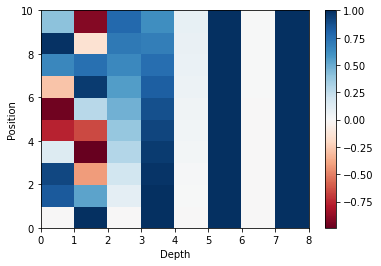

In [ ]:
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, config.d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Tutorial Position lookup

In [ ]:
# position embedding 초기 화, trainable=False인 경우는 학습 되지 않음
pos_embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

In [ ]:
# 모두 1인 값
pos_val_1 = tf.ones_like(enc_tokens)
pos_val_1

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[1, 1, 1, 1, 1, 1]])>

In [ ]:
# 0부터 시작하는 누적 합, exclusive=False인 경우는 1부터 시작
pos_val_2 = tf.math.cumsum(pos_val_1, axis=-1, exclusive=True)
pos_val_2 = tf.cast(pos_val_2, tf.int32)
pos_val_2

<tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5]], dtype=int32)>

In [ ]:
# embedding lookup
pos_val = pos_embedding(pos_val_2)
pos_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  9.9833414e-02,  9.9500418e-01,
          9.9998331e-03,  9.9994999e-01,  9.9999981e-04,  9.9999952e-01],
        [ 9.0929741e-01, -4.1614684e-01,  1.9866933e-01,  9.8006660e-01,
          1.9998666e-02,  9.9980003e-01,  1.9999987e-03,  9.9999797e-01],
        [ 1.4112000e-01, -9.8999250e-01,  2.9552022e-01,  9.5533651e-01,
          2.9995501e-02,  9.9955004e-01,  2.9999956e-03,  9.9999553e-01],
        [-7.5680250e-01, -6.5364361e-01,  3.8941833e-01,  9.2106098e-01,
          3.9989334e-02,  9.9920011e-01,  3.9999895e-03,  9.9999201e-01],
        [-9.5892429e-01,  2.8366220e-01,  4.7942555e-01,  8.7758255e-01,
          4.9979169e-02,  9.9875027e-01,  4.9999794e-03,  9.9998748e-01]]],
      dtype=float32)>

In [ ]:
# embedding lookup 대신 pos_encoding table에서 gather를 통해 직접 조회
pos_val_g = tf.gather(pos_encoding, pos_val_2)
assert np.array_equal(pos_val, tf.cast(pos_val_g, pos_val.dtype))
pos_val_g

<tf.Tensor: shape=(1, 6, 8), dtype=float64, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00],
        [ 8.41470985e-01,  5.40302306e-01,  9.98334166e-02,
          9.95004165e-01,  9.99983333e-03,  9.99950000e-01,
          9.99999833e-04,  9.99999500e-01],
        [ 9.09297427e-01, -4.16146837e-01,  1.98669331e-01,
          9.80066578e-01,  1.99986667e-02,  9.99800007e-01,
          1.99999867e-03,  9.99998000e-01],
        [ 1.41120008e-01, -9.89992497e-01,  2.95520207e-01,
          9.55336489e-01,  2.99955002e-02,  9.99550034e-01,
          2.99999550e-03,  9.99995500e-01],
        [-7.56802495e-01, -6.53643621e-01,  3.89418342e-01,
          9.21060994e-01,  3.99893342e-02,  9.99200107e-01,
          3.99998933e-03,  9.99992000e-01],
        [-9.58924275e-01,  2.83662185e-01,  4.79425539e-01,
          8.77582562e-01,  4.99791693e-02,  9.98750260e-01,
         

### Class

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(config.n_seq, config.d_model)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        angles = [np.power(10000, 2 * (i_ang // 2) / d_model) for i_ang in range(d_model)]
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)

### Test

In [ ]:
# PositionalEmbedding 클래스 시험
pos_embedding = PositionalEmbedding(config)

enc_pos = pos_embedding(enc_tokens)
assert enc_pos.shape == (enc_tokens.shape[0], enc_tokens.shape[1], config.d_model)
enc_pos

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  9.9833414e-02,  9.9500418e-01,
          9.9998331e-03,  9.9994999e-01,  9.9999981e-04,  9.9999952e-01],
        [ 9.0929741e-01, -4.1614684e-01,  1.9866933e-01,  9.8006660e-01,
          1.9998666e-02,  9.9980003e-01,  1.9999987e-03,  9.9999797e-01],
        [ 1.4112000e-01, -9.8999250e-01,  2.9552022e-01,  9.5533651e-01,
          2.9995501e-02,  9.9955004e-01,  2.9999956e-03,  9.9999553e-01],
        [-7.5680250e-01, -6.5364361e-01,  3.8941833e-01,  9.2106098e-01,
          3.9989334e-02,  9.9920011e-01,  3.9999895e-03,  9.9999201e-01],
        [-9.5892429e-01,  2.8366220e-01,  4.7942555e-01,  8.7758255e-01,
          4.9979169e-02,  9.9875027e-01,  4.9999794e-03,  9.9998748e-01]]],
      dtype=float32)>

In [ ]:
dec_pos = pos_embedding(dec_tokens)
assert dec_pos.shape == (dec_tokens.shape[0], dec_tokens.shape[1], config.d_model)
dec_pos

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  9.9833414e-02,  9.9500418e-01,
          9.9998331e-03,  9.9994999e-01,  9.9999981e-04,  9.9999952e-01],
        [ 9.0929741e-01, -4.1614684e-01,  1.9866933e-01,  9.8006660e-01,
          1.9998666e-02,  9.9980003e-01,  1.9999987e-03,  9.9999797e-01],
        [ 1.4112000e-01, -9.8999250e-01,  2.9552022e-01,  9.5533651e-01,
          2.9995501e-02,  9.9955004e-01,  2.9999956e-03,  9.9999553e-01],
        [-7.5680250e-01, -6.5364361e-01,  3.8941833e-01,  9.2106098e-01,
          3.9989334e-02,  9.9920011e-01,  3.9999895e-03,  9.9999201e-01]]],
      dtype=float32)>

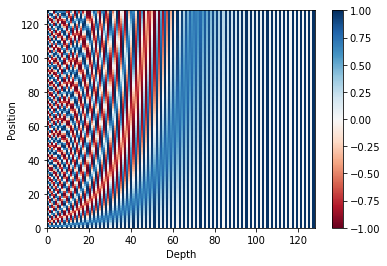

In [ ]:
# 128x128 position encoding table 생성
pos_encoding = PositionalEmbedding.get_sinusoid_encoding(128, 128)
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Pad Mask

![](https://paul-hyun.github.io/assets/transformer/pad_mask.png)

### Tutorial

In [ ]:
# 0인 부분 확인
mask1 = tf.math.equal(enc_tokens, config.i_pad)
mask1

<tf.Tensor: shape=(1, 6), dtype=bool, numpy=array([[False, False, False, False, False,  True]])>

In [ ]:
# boolean에서 flot32로 변경
mask2 = tf.cast(mask1, tf.float32)
mask2

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
# 차원 확대 (차원이 1인 경우에는 차원에 상관없이 연산이 가능)
mask = tf.expand_dims(mask2, axis=1)
mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

### Function

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

### Test

In [ ]:
enc_pad_mask = get_pad_mask(enc_tokens)
# 함수로 구한 mask와 계산한 mask가 같으면 정상
assert np.array_equal(mask, enc_pad_mask)
enc_tokens, enc_pad_mask

(array([[4, 7, 6, 5, 9, 0]]),
 <tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>)

## Ahead mask (Decoder)

![](https://paul-hyun.github.io/assets/transformer/ahead_mask.png)

### Tutorial

In [ ]:
# sequence 개수 추출 (bs, n_seq)
n_seq = tf.shape(dec_tokens)[1]
n_seq

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [ ]:
# 전체가 1일 matrix 생성
ahead_mask1 = tf.ones((n_seq, n_seq))
ahead_mask1

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
# 중간을 기준으로 위쪽을 모두 0으로 변경
# https://www.tensorflow.org/api_docs/python/tf/linalg/band_part#useful_special_cases_2
ahead_mask2 = tf.linalg.band_part(ahead_mask1, -1, 0)
ahead_mask2

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
# 1에서 값을 빼서 0->1, 1->0으로 변경
ahead_mask3 = 1 - ahead_mask2
ahead_mask3

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# batch 차원 추가 (0)
ahead_mask4 = tf.expand_dims(ahead_mask3, axis=0)
ahead_mask4

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], dtype=float32)>

In [ ]:
# pad_mask 조회
pad_mask = get_pad_mask(dec_tokens)
pad_mask

<tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# pad mask 또는 ahead mask인 부분은 모두 mask
mask = tf.maximum(ahead_mask4, pad_mask)
mask

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]], dtype=float32)>

### Function

In [ ]:
def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

### Test

In [ ]:
# 기능 확인
dec_ahead_mask = get_ahead_mask(dec_tokens)
# 함수로 구한 mask와 계산한 mask가 같으면 정상
assert np.array_equal(mask, dec_ahead_mask)
dec_tokens, dec_ahead_mask

(array([[8, 7, 9, 1, 0]]), <tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
 array([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]], dtype=float32)>)

## Scaled dot product attention (Encoder Self Attention)

![](https://paul-hyun.github.io/assets/transformer/scaled_dot_attention_encoder.png)

### Tutorial

In [ ]:
weights = np.random.randint(1, 10, (config.n_vocab, 4)) / 10
weights

array([[0.1, 0.7, 0.3, 0.1],
       [0.6, 0.3, 0.7, 0.4],
       [0.8, 0.1, 0.1, 0.4],
       [0.3, 0.4, 0.2, 0.4],
       [0.2, 0.4, 0.8, 0.2],
       [0.8, 0.5, 0.1, 0.6],
       [0.2, 0.6, 0.5, 0.1],
       [0.9, 0.9, 0.7, 0.9],
       [0.7, 0.4, 0.2, 0.3],
       [0.6, 0.3, 0.6, 0.7]])

In [ ]:
# embedding layer / 기능 확인을 위해 weights를 정수로 초기화 함
int_embedding = tf.keras.layers.Embedding(input_dim=config.n_vocab, output_dim=4, weights=[weights])

In [ ]:
# enc_input pad mask
enc_self_mask = get_pad_mask(enc_tokens)
enc_self_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# Q value
Q = int_embedding(enc_tokens)
Q

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[0.2, 0.4, 0.8, 0.2],
        [0.9, 0.9, 0.7, 0.9],
        [0.2, 0.6, 0.5, 0.1],
        [0.8, 0.5, 0.1, 0.6],
        [0.6, 0.3, 0.6, 0.7],
        [0.1, 0.7, 0.3, 0.1]]], dtype=float32)>

In [ ]:
# Q, K, V 모두 동일한 값
K = Q
V = K

In [ ]:
# attention score
attention_score = tf.matmul(Q, K, transpose_b=True)
attention_score

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0.88000005, 1.2799999 , 0.7       , 0.56000006, 0.86      ,
         0.56      ],
        [1.2799999 , 2.9199998 , 1.1600001 , 1.78      , 1.86      ,
         1.02      ],
        [0.7       , 1.1600001 , 0.66      , 0.57000005, 0.67      ,
         0.6       ],
        [0.56000006, 1.78      , 0.57000005, 1.2600001 , 1.11      ,
         0.52000004],
        [0.86      , 1.86      , 0.67      , 1.11      , 1.3000001 ,
         0.52000004],
        [0.56      , 1.02      , 0.6       , 0.52000004, 0.52000004,
         0.59999996]]], dtype=float32)>

In [ ]:
# scale 계산
scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
scale

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
# attention_score를 scale로 나눔
attention_scaled = tf.math.divide(attention_score, scale)
attention_scaled

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0.44000003, 0.6399999 , 0.35      , 0.28000003, 0.43      ,
         0.28      ],
        [0.6399999 , 1.4599999 , 0.58000004, 0.89      , 0.93      ,
         0.51      ],
        [0.35      , 0.58000004, 0.33      , 0.28500003, 0.335     ,
         0.3       ],
        [0.28000003, 0.89      , 0.28500003, 0.63000005, 0.555     ,
         0.26000002],
        [0.43      , 0.93      , 0.335     , 0.555     , 0.65000004,
         0.26000002],
        [0.28      , 0.51      , 0.3       , 0.26000002, 0.26000002,
         0.29999998]]], dtype=float32)>

In [ ]:
# mask 해야할 부분이 매우 큰 음수를 뺌
attention_masked = attention_scaled - 1.e9 * enc_self_mask
attention_masked

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[ 4.4000003e-01,  6.3999993e-01,  3.4999999e-01,  2.8000003e-01,
          4.3000001e-01, -1.0000000e+09],
        [ 6.3999993e-01,  1.4599999e+00,  5.8000004e-01,  8.8999999e-01,
          9.3000001e-01, -1.0000000e+09],
        [ 3.4999999e-01,  5.8000004e-01,  3.3000001e-01,  2.8500003e-01,
          3.3500001e-01, -1.0000000e+09],
        [ 2.8000003e-01,  8.8999999e-01,  2.8500003e-01,  6.3000005e-01,
          5.5500001e-01, -1.0000000e+09],
        [ 4.3000001e-01,  9.3000001e-01,  3.3500001e-01,  5.5500001e-01,
          6.5000004e-01, -1.0000000e+09],
        [ 2.8000000e-01,  5.0999999e-01,  3.0000001e-01,  2.6000002e-01,
          2.6000002e-01, -1.0000000e+09]]], dtype=float32)>

In [ ]:
# attention 확률분포 계산
attention_prob = tf.nn.softmax(attention_masked, axis=-1)
attention_prob

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0.20090295, 0.2453834 , 0.18361148, 0.1711982 , 0.19890393,
         0.        ],
        [0.14635466, 0.33229822, 0.13783166, 0.1879231 , 0.1955924 ,
         0.        ],
        [0.19376172, 0.24386853, 0.189925  , 0.18156783, 0.190877  ,
         0.        ],
        [0.15195161, 0.2796565 , 0.15271327, 0.2156296 , 0.20004895,
         0.        ],
        [0.16842617, 0.27768782, 0.1531622 , 0.19085187, 0.20987193,
         0.        ],
        [0.19086887, 0.24022757, 0.19472468, 0.18708941, 0.18708941,
         0.        ]]], dtype=float32)>

In [ ]:
# attention output 계산
attention_output = tf.matmul(attention_prob, V)
attention_output

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[0.5540489 , 0.5566434 , 0.5607587 , 0.52133846],
        [0.6235996 , 0.59294856, 0.55475605, 0.59179103],
        [0.55599946, 0.55898833, 0.55336285, 0.5197811 ],
        [0.60515684, 0.5719289 , 0.5352698 , 0.56676453],
        [0.5928414 , 0.5675743 , 0.55071187, 0.56034195],
        [0.5552487 , 0.5590587 , 0.5491793 , 0.5170673 ]]], dtype=float32)>

### Class

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

### Test

In [ ]:
# ScaleDotProductAttention 클래스 기능 확인
attention = ScaleDotProductAttention()

attn_out = attention(Q, K, V, enc_self_mask)
# class 값과 직접 계산한 attention_output과 동일하면 정상
assert np.array_equal(attention_output, attn_out)
attn_out

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[0.5540489 , 0.5566434 , 0.5607587 , 0.52133846],
        [0.6235996 , 0.59294856, 0.55475605, 0.59179103],
        [0.55599946, 0.55898833, 0.55336285, 0.5197811 ],
        [0.60515684, 0.5719289 , 0.5352698 , 0.56676453],
        [0.5928414 , 0.5675743 , 0.55071187, 0.56034195],
        [0.5552487 , 0.5590587 , 0.5491793 , 0.5170673 ]]], dtype=float32)>

## Scaled dot product attention (Decoder Masked Self Attentio)

![](https://paul-hyun.github.io/assets/transformer/scaled_dot_attention_decoder.png)

### Tutorial

In [ ]:
# ahead mask 계산
dec_self_mask = get_ahead_mask(dec_tokens)
dec_self_mask

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# Q
Q = int_embedding(dec_tokens)
Q

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.7, 0.4, 0.2, 0.3],
        [0.9, 0.9, 0.7, 0.9],
        [0.6, 0.3, 0.6, 0.7],
        [0.6, 0.3, 0.7, 0.4],
        [0.1, 0.7, 0.3, 0.1]]], dtype=float32)>

In [ ]:
# Q, K, V는 모두 같음
K = Q
V = K

In [ ]:
# attention score 계산
attention_score = tf.matmul(Q, K, transpose_b=True)
attention_score

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0.78000003, 1.4       , 0.87      , 0.8       , 0.44      ],
        [1.4       , 2.9199998 , 1.86      , 1.66      , 1.02      ],
        [0.87      , 1.86      , 1.3000001 , 1.15      , 0.52000004],
        [0.8       , 1.66      , 1.15      , 1.1       , 0.52000004],
        [0.44      , 1.02      , 0.52000004, 0.52000004, 0.59999996]]],
      dtype=float32)>

In [ ]:
# attention score를 scal로 나눔
attention_scaled = tf.math.divide(attention_score, scale)
attention_scaled

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0.39000002, 0.7       , 0.435     , 0.4       , 0.22      ],
        [0.7       , 1.4599999 , 0.93      , 0.83      , 0.51      ],
        [0.435     , 0.93      , 0.65000004, 0.575     , 0.26000002],
        [0.4       , 0.83      , 0.575     , 0.55      , 0.26000002],
        [0.22      , 0.51      , 0.26000002, 0.26000002, 0.29999998]]],
      dtype=float32)>

In [ ]:
# mask 해야할 부분이 매우 큰 음수를 뺌
attention_masked = attention_scaled - 1.e9 * dec_self_mask
attention_masked

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[ 3.9000002e-01, -1.0000000e+09, -1.0000000e+09, -1.0000000e+09,
         -1.0000000e+09],
        [ 6.9999999e-01,  1.4599999e+00, -1.0000000e+09, -1.0000000e+09,
         -1.0000000e+09],
        [ 4.3500000e-01,  9.3000001e-01,  6.5000004e-01, -1.0000000e+09,
         -1.0000000e+09],
        [ 4.0000001e-01,  8.2999998e-01,  5.7499999e-01,  5.5000001e-01,
         -1.0000000e+09],
        [ 2.2000000e-01,  5.0999999e-01,  2.6000002e-01,  2.6000002e-01,
         -1.0000000e+09]]], dtype=float32)>

In [ ]:
# attention 확률분포 계산
attention_prob = tf.nn.softmax(attention_masked, axis=-1)
attention_prob

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.31864628, 0.68135375, 0.        , 0.        , 0.        ],
        [0.25770804, 0.42276955, 0.31952235, 0.        , 0.        ],
        [0.20448485, 0.31434587, 0.2435918 , 0.2375775 , 0.        ],
        [0.22634424, 0.30249268, 0.23558153, 0.23558153, 0.        ]]],
      dtype=float32)>

In [ ]:
# attention output 계산
attention_output = tf.matmul(attention_prob, V)
attention_output

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.7       , 0.4       , 0.2       , 0.3       ],
        [0.83627075, 0.7406769 , 0.5406769 , 0.70881224],
        [0.7526016 , 0.5794325 , 0.5391937 , 0.68147063],
        [0.7147522 , 0.509056  , 0.5733984 , 0.609802  ],
        [0.7133822 , 0.50413   , 0.56326973, 0.5992864 ]]], dtype=float32)>

### Test

In [ ]:
# ScaleDotProductAttention 클래스 기능 확인
attention = ScaleDotProductAttention()

attn_out = attention(Q, K, V, dec_self_mask)
# class 값과 직접 계산한 attention_output과 동일하면 정상
assert np.array_equal(attention_output, attn_out)
attn_out

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.7       , 0.4       , 0.2       , 0.3       ],
        [0.83627075, 0.7406769 , 0.5406769 , 0.70881224],
        [0.7526016 , 0.5794325 , 0.5391937 , 0.68147063],
        [0.7147522 , 0.509056  , 0.5733984 , 0.609802  ],
        [0.7133822 , 0.50413   , 0.56326973, 0.5992864 ]]], dtype=float32)>

## Scaled dot product attention (Encoder Decoder Attention)

![](https://paul-hyun.github.io/assets/transformer/scaled_dot_attention_ende.png)

### Tutorial

In [ ]:
# K pad mask
ende_attn_mask = get_pad_mask(enc_tokens)
ende_attn_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
Q = int_embedding(dec_tokens)
Q

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.7, 0.4, 0.2, 0.3],
        [0.9, 0.9, 0.7, 0.9],
        [0.6, 0.3, 0.6, 0.7],
        [0.6, 0.3, 0.7, 0.4],
        [0.1, 0.7, 0.3, 0.1]]], dtype=float32)>

In [ ]:
K = int_embedding(enc_tokens)
V = K
K

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[0.2, 0.4, 0.8, 0.2],
        [0.9, 0.9, 0.7, 0.9],
        [0.2, 0.6, 0.5, 0.1],
        [0.8, 0.5, 0.1, 0.6],
        [0.6, 0.3, 0.6, 0.7],
        [0.1, 0.7, 0.3, 0.1]]], dtype=float32)>

In [ ]:
# attention score
attention_score = tf.matmul(Q, K, transpose_b=True)
attention_score

<tf.Tensor: shape=(1, 5, 6), dtype=float32, numpy=
array([[[0.52000004, 1.4       , 0.51000005, 0.96      , 0.87      ,
         0.44      ],
        [1.2799999 , 2.9199998 , 1.1600001 , 1.78      , 1.86      ,
         1.02      ],
        [0.86      , 1.86      , 0.67      , 1.11      , 1.3000001 ,
         0.52000004],
        [0.88      , 1.66      , 0.69      , 0.94      , 1.15      ,
         0.52000004],
        [0.56      , 1.02      , 0.6       , 0.52000004, 0.52000004,
         0.59999996]]], dtype=float32)>

In [ ]:
# scale 계산
scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
scale

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
# attention_score를 scale로 나눔
attention_scaled = tf.math.divide(attention_score, scale)
attention_scaled

<tf.Tensor: shape=(1, 5, 6), dtype=float32, numpy=
array([[[0.26000002, 0.7       , 0.25500003, 0.48      , 0.435     ,
         0.22      ],
        [0.6399999 , 1.4599999 , 0.58000004, 0.89      , 0.93      ,
         0.51      ],
        [0.43      , 0.93      , 0.335     , 0.555     , 0.65000004,
         0.26000002],
        [0.44      , 0.83      , 0.345     , 0.47      , 0.575     ,
         0.26000002],
        [0.28      , 0.51      , 0.3       , 0.26000002, 0.26000002,
         0.29999998]]], dtype=float32)>

In [ ]:
# mask 해야할 부분이 매우 큰 음수를 뺌
attention_masked = attention_scaled - 1.e9 * ende_attn_mask
attention_masked

<tf.Tensor: shape=(1, 5, 6), dtype=float32, numpy=
array([[[ 2.6000002e-01,  6.9999999e-01,  2.5500003e-01,  4.7999999e-01,
          4.3500000e-01, -1.0000000e+09],
        [ 6.3999993e-01,  1.4599999e+00,  5.8000004e-01,  8.8999999e-01,
          9.3000001e-01, -1.0000000e+09],
        [ 4.3000001e-01,  9.3000001e-01,  3.3500001e-01,  5.5500001e-01,
          6.5000004e-01, -1.0000000e+09],
        [ 4.4000000e-01,  8.2999998e-01,  3.4500000e-01,  4.7000000e-01,
          5.7499999e-01, -1.0000000e+09],
        [ 2.8000000e-01,  5.0999999e-01,  3.0000001e-01,  2.6000002e-01,
          2.6000002e-01, -1.0000000e+09]]], dtype=float32)>

In [ ]:
# attention 확률분포 계산
attention_prob = tf.nn.softmax(attention_masked, axis=-1)
attention_prob

<tf.Tensor: shape=(1, 5, 6), dtype=float32, numpy=
array([[[0.16708319, 0.25943124, 0.16624986, 0.20819846, 0.19903721,
         0.        ],
        [0.14635466, 0.33229822, 0.13783166, 0.1879231 , 0.1955924 ,
         0.        ],
        [0.16842617, 0.27768782, 0.1531622 , 0.19085187, 0.20987193,
         0.        ],
        [0.17981263, 0.26557976, 0.16351673, 0.18528873, 0.20580216,
         0.        ],
        [0.19086887, 0.24022757, 0.19472468, 0.18708941, 0.18708941,
         0.        ]]], dtype=float32)>

In [ ]:
# attention output 계산
attention_output = tf.matmul(attention_prob, V)
attention_output

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.5861358 , 0.5638817 , 0.53863555, 0.54777485],
        [0.6235996 , 0.59294856, 0.55475605, 0.59179103],
        [0.5928414 , 0.5675743 , 0.55071187, 0.56034195],
        [0.5793999 , 0.5634419 , 0.55352443, 0.5465707 ],
        [0.5552487 , 0.5590587 , 0.5491793 , 0.5170673 ]]], dtype=float32)>

### Test

In [ ]:
# ScaleDotProductAttention 클래스 기능 확인
attention = ScaleDotProductAttention()

attn_out = attention(Q, K, V, ende_attn_mask)
# class 값과 직접 계산한 attention_output과 동일하면 정상
assert np.array_equal(attention_output, attn_out)
attn_out

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.5861358 , 0.5638817 , 0.53863555, 0.54777485],
        [0.6235996 , 0.59294856, 0.55475605, 0.59179103],
        [0.5928414 , 0.5675743 , 0.55071187, 0.56034195],
        [0.5793999 , 0.5634419 , 0.55352443, 0.5465707 ],
        [0.5552487 , 0.5590587 , 0.5491793 , 0.5170673 ]]], dtype=float32)>

## Multi Head Attention

![](https://paul-hyun.github.io/assets/transformer/multihead_attention.png)

### Tutorial

In [ ]:
# SharedEmbedding
embedding = SharedEmbedding(config)

In [ ]:
# Q
Q = embedding(dec_tokens)
Q

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.8684977 , -0.10887106, -1.6283252 , -0.09412991,
         -0.9135378 , -0.5230187 ,  0.18054976,  1.0659311 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [ 0.8284642 ,  1.1036007 , -0.78627795,  1.6918567 ,
         -0.34767905,  1.3073093 ,  0.2444622 , -0.7029787 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
# K, V
K = embedding(enc_tokens)
V = K
K

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.19626832,  1.6160245 , -1.5125287 ,  0.8802097 ,
          0.43964735, -0.49681696,  0.9233131 , -1.0172113 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.39263427, -1.7194668 ,  1.8227654 , -0.15567164,
         -0.6654087 ,  0.68538827,  0.68061626,  0.74703187],
        [-1.3610662 , -1.8012775 , -0.09980725, -0.69201565,
         -1.6705056 , -0.07607771, -0.5028183 , -0.22716261],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
# Q에 Weight W_Q 곱함
W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
Q_multi_1 = W_Q(Q)
Q_multi_1

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.60726416,  0.361799  ,  0.32159328,  1.0295479 ,
          2.0804245 , -0.75704414, -0.34533685,  1.0343486 ],
        [ 0.4654265 ,  0.6619142 , -0.23965865, -0.07134926,
          1.7227608 ,  0.51219004, -0.8823885 ,  0.36687952],
        [ 0.541306  , -0.9074034 ,  0.27299052, -0.47244957,
          0.6666978 , -0.36000645,  0.40457243,  0.09094184],
        [ 0.7040179 ,  1.3128388 ,  0.02026616, -0.20661889,
          1.2101818 ,  0.39174786, -0.87256515,  2.2761583 ],
        [-0.39734784,  1.7864554 , -0.09988443,  0.53837633,
          0.7466715 , -0.85641634,  0.32024756,  2.4470556 ]]],
      dtype=float32)>

In [ ]:
# 여러 개의 head로 분할
Q_multi_2 = tf.reshape(Q_multi_1, [tf.shape(Q)[0], -1, config.n_head, config.d_head])  # (bs, n_seq, n_head, d_head)
Q_multi_2

<tf.Tensor: shape=(1, 5, 2, 4), dtype=float32, numpy=
array([[[[ 0.60726416,  0.361799  ,  0.32159328,  1.0295479 ],
         [ 2.0804245 , -0.75704414, -0.34533685,  1.0343486 ]],

        [[ 0.4654265 ,  0.6619142 , -0.23965865, -0.07134926],
         [ 1.7227608 ,  0.51219004, -0.8823885 ,  0.36687952]],

        [[ 0.541306  , -0.9074034 ,  0.27299052, -0.47244957],
         [ 0.6666978 , -0.36000645,  0.40457243,  0.09094184]],

        [[ 0.7040179 ,  1.3128388 ,  0.02026616, -0.20661889],
         [ 1.2101818 ,  0.39174786, -0.87256515,  2.2761583 ]],

        [[-0.39734784,  1.7864554 , -0.09988443,  0.53837633],
         [ 0.7466715 , -0.85641634,  0.32024756,  2.4470556 ]]]],
      dtype=float32)>

In [ ]:
# bs, number of head, seq length, dim of head 가 되도록 정렬
Q_multi = tf.transpose(Q_multi_2, [0, 2, 1, 3])  # (bs, h_head, n_seq, d_head)
Q_multi

<tf.Tensor: shape=(1, 2, 5, 4), dtype=float32, numpy=
array([[[[ 0.60726416,  0.361799  ,  0.32159328,  1.0295479 ],
         [ 0.4654265 ,  0.6619142 , -0.23965865, -0.07134926],
         [ 0.541306  , -0.9074034 ,  0.27299052, -0.47244957],
         [ 0.7040179 ,  1.3128388 ,  0.02026616, -0.20661889],
         [-0.39734784,  1.7864554 , -0.09988443,  0.53837633]],

        [[ 2.0804245 , -0.75704414, -0.34533685,  1.0343486 ],
         [ 1.7227608 ,  0.51219004, -0.8823885 ,  0.36687952],
         [ 0.6666978 , -0.36000645,  0.40457243,  0.09094184],
         [ 1.2101818 ,  0.39174786, -0.87256515,  2.2761583 ],
         [ 0.7466715 , -0.85641634,  0.32024756,  2.4470556 ]]]],
      dtype=float32)>

In [ ]:
# K multi head로 분할
W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
K_multi = tf.transpose(tf.reshape(W_K(K), [tf.shape(K)[0], -1, config.n_head, config.d_head]), [0, 2, 1, 3])  # (bs, h_head, n_seq, d_head)
K_multi

<tf.Tensor: shape=(1, 2, 6, 4), dtype=float32, numpy=
array([[[[ 0.44157648,  0.6153864 ,  1.0823401 , -0.86922544],
         [-0.07734159, -1.2439793 , -0.5060919 ,  0.7221384 ],
         [-0.3402935 , -0.2853378 , -1.085498  ,  1.3541912 ],
         [-0.669067  , -0.89185184, -1.4189061 ,  0.1956557 ],
         [-0.09156862,  0.6330453 ,  0.3475441 , -0.74757963],
         [ 1.2972405 ,  0.22881109,  0.81454617,  1.3349972 ]],

        [[ 1.8166772 , -1.2446975 ,  0.44066074, -0.86773616],
         [ 1.7250284 ,  0.31310382,  1.3237872 , -1.119676  ],
         [-0.2359419 ,  2.147542  , -0.1751713 ,  0.5203572 ],
         [ 0.38042784,  0.8608245 ,  0.5974173 , -0.59115237],
         [-0.35097072, -1.2586634 , -0.368381  , -0.14807175],
         [ 1.1672742 ,  0.70805603,  0.5896891 , -0.94566447]]]],
      dtype=float32)>

In [ ]:
# V multi head로 분할
W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
V_multi = tf.transpose(tf.reshape(W_V(V), [tf.shape(V)[0], -1, config.n_head, config.d_head]), [0, 2, 1, 3])  # (bs, h_head, n_seq, d_head)
V_multi

<tf.Tensor: shape=(1, 2, 6, 4), dtype=float32, numpy=
array([[[[-0.05052545,  1.3679097 ,  0.06428895, -1.794766  ],
         [ 0.30957353, -1.4764541 , -0.75112426,  0.456041  ],
         [-0.86460584, -2.518207  ,  0.688274  ,  2.2011814 ],
         [-0.3547636 , -1.8334684 , -0.7684364 ,  1.4162139 ],
         [-0.61955553,  1.0833172 , -0.48860148, -1.2713012 ],
         [ 0.90829   , -0.8477764 ,  2.1262171 ,  0.9595524 ]],

        [[-1.1524616 , -0.30813012, -0.50484705, -0.3681637 ],
         [-0.10167964,  1.8378878 , -0.3448023 ,  0.42790195],
         [-0.23112503,  0.55959207, -0.5577835 , -0.05705123],
         [ 0.0460737 ,  1.2424753 ,  0.45248488,  1.4593086 ],
         [-0.79891145, -0.7697486 ,  0.7987878 ,  0.49396542],
         [-0.48566887, -0.09066994, -1.72011   , -0.80178815]]]],
      dtype=float32)>

In [ ]:
# pad mask 구함 / decoder 일 경우는 ahead mask 구하면 됨
ende_mask = get_pad_mask(enc_tokens)
ende_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# Q_multi, K_mulit, V_multi와 동일한 차원이 되도록 차원을 늘려 줌
ende_mask_multi = tf.expand_dims(ende_mask, axis=1)
ende_mask_multi

<tf.Tensor: shape=(1, 1, 1, 6), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0., 1.]]]], dtype=float32)>

In [ ]:
# ScaleDotProductAttention을 여러 head 동시 실행 함
attention = ScaleDotProductAttention()
attn_val_multi = attention(Q_multi, K_multi, V_multi, ende_mask_multi)  # (bs, n_head, Q_len, d_head)
attn_val_multi

<tf.Tensor: shape=(1, 2, 5, 4), dtype=float32, numpy=
array([[[[-0.345626  , -0.84792   , -0.11944495,  0.3660898 ],
         [-0.3459013 , -0.35639045, -0.20108911, -0.07225244],
         [-0.21888992, -0.54503214, -0.33133984,  0.01956925],
         [-0.3329003 ,  0.2834197 , -0.16911805, -0.6665487 ],
         [-0.43358487, -0.34126753, -0.10640377, -0.03630598]],

        [[-0.77040124,  0.25091764, -0.27838963,  0.02456311],
         [-0.47615066,  0.6410982 , -0.23332983,  0.24423583],
         [-0.54133904,  0.5510782 , -0.13543905,  0.28242606],
         [-0.39123473,  0.46834344, -0.24057712,  0.19138525],
         [-0.6347243 ,  0.14110588, -0.01146942,  0.23022273]]]],
      dtype=float32)>

In [ ]:
attention_transpose = tf.transpose(attn_val_multi, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
attention_transpose

<tf.Tensor: shape=(1, 5, 2, 4), dtype=float32, numpy=
array([[[[-0.345626  , -0.84792   , -0.11944495,  0.3660898 ],
         [-0.77040124,  0.25091764, -0.27838963,  0.02456311]],

        [[-0.3459013 , -0.35639045, -0.20108911, -0.07225244],
         [-0.47615066,  0.6410982 , -0.23332983,  0.24423583]],

        [[-0.21888992, -0.54503214, -0.33133984,  0.01956925],
         [-0.54133904,  0.5510782 , -0.13543905,  0.28242606]],

        [[-0.3329003 ,  0.2834197 , -0.16911805, -0.6665487 ],
         [-0.39123473,  0.46834344, -0.24057712,  0.19138525]],

        [[-0.43358487, -0.34126753, -0.10640377, -0.03630598],
         [-0.6347243 ,  0.14110588, -0.01146942,  0.23022273]]]],
      dtype=float32)>

In [ ]:
attention_concat = tf.reshape(attention_transpose, [tf.shape(Q)[0], -1, config.n_head * config.d_head])  # (bs, Q_len, n_head * d_head)
attention_concat

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-0.345626  , -0.84792   , -0.11944495,  0.3660898 ,
         -0.77040124,  0.25091764, -0.27838963,  0.02456311],
        [-0.3459013 , -0.35639045, -0.20108911, -0.07225244,
         -0.47615066,  0.6410982 , -0.23332983,  0.24423583],
        [-0.21888992, -0.54503214, -0.33133984,  0.01956925,
         -0.54133904,  0.5510782 , -0.13543905,  0.28242606],
        [-0.3329003 ,  0.2834197 , -0.16911805, -0.6665487 ,
         -0.39123473,  0.46834344, -0.24057712,  0.19138525],
        [-0.43358487, -0.34126753, -0.10640377, -0.03630598,
         -0.6347243 ,  0.14110588, -0.01146942,  0.23022273]]],
      dtype=float32)>

In [ ]:
WO = tf.keras.layers.Dense(config.d_model)
attention_output = WO(attention_concat)
attention_output

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.49050614, -0.80502474, -0.45042852,  0.4577768 ,
          0.06806507, -0.33055836,  0.11655101,  1.106462  ],
        [ 0.38006845, -0.673133  , -0.522027  ,  0.21313778,
          0.2849807 ,  0.02968239, -0.01816979,  0.7601285 ],
        [ 0.40359265, -0.77938026, -0.3197016 ,  0.25294086,
          0.29103556, -0.050294  ,  0.03342267,  0.80691427],
        [ 0.1614267 , -0.2801389 , -0.42321342, -0.3257166 ,
          0.22512603,  0.12906912,  0.18890846, -0.07056847],
        [ 0.26344994, -0.6158227 , -0.15614235, -0.08349588,
          0.01159389, -0.32596976,  0.5276855 ,  0.53101057]]],
      dtype=float32)>

### Class

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

### Test

In [ ]:
attention = MultiHeadAttention(config)

attn_out = attention(Q, K, V, ende_mask)
# Q와 output의 shape 같으면 정상 (W_Q, W_K, W_V, W_O 값이 랜덤하게 초기화 되므로 값은 달라 짐)
assert Q.shape == attn_out.shape
attn_out

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.7263753 ,  0.01100423, -0.14146954, -1.474141  ,
          0.67914605,  0.5476541 , -1.3935212 ,  1.6705611 ],
        [-1.3784305 ,  0.7695727 , -0.45037356, -1.3775396 ,
          0.872072  , -0.35682335, -0.6400545 ,  0.96092796],
        [-0.9750036 , -0.19607304, -0.03950725, -0.8575573 ,
          0.25044277,  0.8432678 , -1.0721037 ,  1.1410965 ],
        [-0.5620066 ,  0.60790604, -0.26716492, -0.5765985 ,
          0.34476855, -0.15077235, -0.14507543,  0.39121908],
        [-1.3501408 ,  0.18068257, -0.08150227, -1.1048425 ,
          0.5075927 ,  0.4860721 , -0.92029124,  1.2991695 ]]],
      dtype=float32)>

## Feed Forward

![](https://paul-hyun.github.io/assets/transformer/feedforward.png)

### Tutorial

In [ ]:
# sublayer output
sublayer_output = embedding(enc_tokens)
sublayer_output

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.19626832,  1.6160245 , -1.5125287 ,  0.8802097 ,
          0.43964735, -0.49681696,  0.9233131 , -1.0172113 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.39263427, -1.7194668 ,  1.8227654 , -0.15567164,
         -0.6654087 ,  0.68538827,  0.68061626,  0.74703187],
        [-1.3610662 , -1.8012775 , -0.09980725, -0.69201565,
         -1.6705056 , -0.07607771, -0.5028183 , -0.22716261],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
# dense 1: d_mdoel -> d_ff
ff_val_1 = tf.keras.layers.Dense(config.d_ff)(sublayer_output)
ff_val_1

<tf.Tensor: shape=(1, 6, 32), dtype=float32, numpy=
array([[[ 7.7031565e-01, -6.3997334e-01,  9.1023549e-02,  1.3620909e-01,
         -6.6182727e-01,  2.5415921e-01,  3.4217364e-01, -3.8794968e-01,
         -1.1187069e-02,  3.5169867e-01,  5.4275781e-01, -9.4716631e-02,
          4.2744774e-01,  6.4273638e-01, -6.2227813e-03,  4.0499967e-01,
          5.0659740e-01, -1.2033995e-01,  8.4220308e-01, -3.2478133e-01,
         -1.6106592e-01,  6.0928249e-01, -3.1512684e-01, -2.2889431e-01,
          1.0023953e+00,  4.4507617e-01,  2.9803553e-01, -7.0957199e-02,
         -1.0344104e+00, -4.9265414e-01,  4.5147827e-01, -2.4699213e-01],
        [ 5.7942402e-01, -3.1980451e-02,  7.1110243e-01, -2.4003801e-01,
         -8.1442392e-01, -1.2713453e+00, -7.0793539e-01,  4.6208960e-01,
         -2.5861037e-01,  1.4218054e+00,  1.8033302e-01, -7.5368106e-02,
          5.5270493e-01,  8.0002591e-02, -1.9854777e-01,  1.0054317e+00,
          5.7834148e-01, -1.2824628e+00, -1.6690974e-01,  3.5366511e-01

In [ ]:
# relu: 0보다 작은 값은 모두 0
ff_val_2 = tf.nn.relu(ff_val_1)
ff_val_2

<tf.Tensor: shape=(1, 6, 32), dtype=float32, numpy=
array([[[0.77031565, 0.        , 0.09102355, 0.13620909, 0.        ,
         0.2541592 , 0.34217364, 0.        , 0.        , 0.35169867,
         0.5427578 , 0.        , 0.42744774, 0.6427364 , 0.        ,
         0.40499967, 0.5065974 , 0.        , 0.8422031 , 0.        ,
         0.        , 0.6092825 , 0.        , 0.        , 1.0023953 ,
         0.44507617, 0.29803553, 0.        , 0.        , 0.        ,
         0.45147827, 0.        ],
        [0.579424  , 0.        , 0.7111024 , 0.        , 0.        ,
         0.        , 0.        , 0.4620896 , 0.        , 1.4218054 ,
         0.18033302, 0.        , 0.55270493, 0.08000259, 0.        ,
         1.0054317 , 0.5783415 , 0.        , 0.        , 0.3536651 ,
         0.        , 0.        , 0.71466655, 0.74253523, 0.11395467,
         0.        , 0.        , 0.        , 0.46452346, 0.        ,
         0.        , 0.25336075],
        [0.        , 0.05250622, 0.05735329, 0.     

In [ ]:
# dense 2: d_ff -> d_model
ff_val = tf.keras.layers.Dense(config.d_model)(ff_val_2)
ff_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.05343075, -0.12957543, -0.12799205,  0.22800428,
          0.37556288,  0.02002757, -0.5281978 ,  0.3447255 ],
        [ 0.4311106 ,  0.4739277 ,  0.10379799,  0.65783656,
         -0.13527882,  0.0956341 , -0.27491826, -0.7066558 ],
        [ 0.5946567 ,  0.9119929 , -0.32639787,  0.37083983,
          0.6611173 , -0.00635346,  0.19086611, -0.0410204 ],
        [ 0.3917761 ,  0.548897  , -0.10651836,  0.2984062 ,
         -0.07401256,  0.02801821,  0.42922768, -0.3290153 ],
        [ 0.1652643 ,  0.12299664,  0.24812295,  0.7795001 ,
          0.21664938,  0.48855445,  0.11982806,  0.90903956],
        [-0.50531423, -0.19958912, -0.57119405,  0.34657502,
          0.03725421, -0.57696265, -1.0532655 ,  0.19136593]]],
      dtype=float32)>

### Class

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

### Test

In [ ]:
# feed-forward class 동작 확인
feed_forward = PositionWiseFeedForward(config)

ff_val = feed_forward(sublayer_output)
# 입력과 출력의 shape가 같의면 정상 (W_1, W_2 값이 랜덤초기화 되므로 값은 변경 됨)
assert ff_val.shape == sublayer_output.shape
ff_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3864193 ,  0.6548004 , -0.9338117 ,  0.2610803 ,
          0.03351761,  1.0447208 ,  0.77503675, -0.12114956],
        [-0.5972206 ,  0.18925105, -0.06597053, -0.37621737,
         -0.23455417,  1.5406342 ,  0.45216763,  0.7366392 ],
        [-0.04632387,  0.10500712,  0.22665875, -0.30265856,
         -0.77859014,  0.0451427 ,  0.05126077, -0.00218356],
        [-0.7762042 , -0.29549295,  0.351876  , -0.13449734,
         -0.13364096,  0.82650745, -0.20703031,  0.5175292 ],
        [ 0.26921114,  0.25551227, -0.37782532,  0.0591877 ,
         -0.38833007,  0.08096397,  0.00456275,  0.44020793],
        [ 0.6045598 ,  0.11301193, -0.6297971 ,  0.12454663,
         -0.67571384,  0.29747707,  0.19916855, -0.18869305]]],
      dtype=float32)>

## Encoder Layer

![](https://paul-hyun.github.io/assets/transformer/encoder_layer.png)

### Tutorial

In [ ]:
# encoder self attetnion mask
self_mask = get_pad_mask(enc_tokens)
self_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# encoder embedding
enc_embed = embedding(enc_tokens)
enc_embed

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.19626832,  1.6160245 , -1.5125287 ,  0.8802097 ,
          0.43964735, -0.49681696,  0.9233131 , -1.0172113 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.39263427, -1.7194668 ,  1.8227654 , -0.15567164,
         -0.6654087 ,  0.68538827,  0.68061626,  0.74703187],
        [-1.3610662 , -1.8012775 , -0.09980725, -0.69201565,
         -1.6705056 , -0.07607771, -0.5028183 , -0.22716261],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
# MultiHeadAttention
self_attention = MultiHeadAttention(config)
self_attn_val = self_attention(enc_embed, enc_embed, enc_embed, self_mask)
self_attn_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.06125214, -0.7417861 , -0.24070372, -0.13314432,
          0.7362004 ,  0.05651651, -0.24332069, -0.39187843],
        [-0.1842178 , -0.6306483 , -0.37439248, -0.06857631,
          0.5838019 ,  0.17402954, -0.20345752, -0.7997296 ],
        [-0.09924537,  0.4825186 ,  0.6180561 , -0.7602583 ,
          0.32308683, -0.5280105 , -0.56502706,  0.25898117],
        [-0.34235004, -0.1004412 ,  0.05761168, -0.13948208,
          0.07773668,  0.08463571, -0.31411588, -0.46418265],
        [ 0.12851137, -0.6052733 , -0.07221878, -0.2990629 ,
          0.7786447 , -0.08854968, -0.33206263, -0.17925915],
        [ 0.21461184, -0.42240646, -0.06978093, -0.35446543,
          0.82694685, -0.15981808, -0.30214185, -0.10174477]]],
      dtype=float32)>

In [ ]:
norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
dropout = tf.keras.layers.Dropout(config.dropout)
norm1_val = norm1(enc_embed + dropout(self_attn_val))
norm1_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.23391868,  0.8324776 , -1.7176285 ,  0.70904917,
          1.1252062 , -0.44335523,  0.6439511 , -1.3836191 ],
        [-1.3507798 , -0.4014547 , -0.7609008 ,  1.3623654 ,
          0.15200175,  1.7859901 , -0.2399066 , -0.54731506],
        [-0.53051513, -1.2079626 ,  2.136019  , -0.9160794 ,
         -0.39453095,  0.05981681,  0.02182089,  0.8314314 ],
        [-1.107734  , -1.3979137 ,  1.3231605 ,  0.16816027,
         -0.9458217 ,  1.3974291 ,  0.1894714 ,  0.37324792],
        [ 0.39393008,  0.43556777, -0.20495975,  0.40402094,
          1.718561  , -2.0491915 , -0.4823121 , -0.21561658],
        [-1.3229212 ,  0.43036264, -1.5289928 , -0.76475126,
          1.0128042 ,  0.18680756,  1.1996762 ,  0.78701496]]],
      dtype=float32)>

In [ ]:
ffn = PositionWiseFeedForward(config)
ffn_val = ffn(norm1_val)
ffn_val

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.33255947,  0.6135318 ,  0.20051411, -0.07957102,
          0.75597715, -0.07830818,  0.72060686, -0.29344255],
        [-0.41146573,  0.05666247, -0.22377071, -0.3695034 ,
          0.2657462 , -0.26741302,  0.56244975, -0.14689459],
        [ 0.5862982 , -0.60902685, -0.23588455,  0.7762841 ,
          0.48423076, -0.14400677,  1.1370949 , -0.17276284],
        [ 0.0642384 , -0.79433984,  0.01329809,  0.21145213,
          0.5619661 ,  0.07592953,  0.59293854,  0.30395535],
        [ 0.09608699,  1.0420612 , -0.59164256,  0.06332767,
          0.70619184, -0.12454826,  1.2926267 , -0.30812186],
        [ 0.46222466, -0.02264546, -0.22483444, -0.1521084 ,
         -0.61860794, -0.45302588,  0.32223752, -0.51863307]]],
      dtype=float32)>

In [ ]:
norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
enc_out = norm2(norm1_val + dropout(ffn_val))
enc_out

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.22505721,  0.9862793 , -1.3374443 ,  0.34594396,
          1.3275489 , -0.55679756,  0.92240393, -1.4628772 ],
        [-1.6727691 , -0.27429587, -0.9056069 ,  1.0454468 ,
          0.47803366,  1.5641223 ,  0.38410366, -0.61903447],
        [-0.16865912, -2.005106  ,  1.6399177 , -0.36044392,
         -0.13540028, -0.30591714,  0.91307634,  0.42253226],
        [-0.9955915 , -1.9712936 ,  1.0258316 ,  0.21313058,
         -0.43532383,  1.1421081 ,  0.5552482 ,  0.46589056],
        [ 0.16348061,  0.9040361 , -0.8012841 ,  0.1464828 ,
          1.6142321 , -1.8339232 ,  0.40365407, -0.59667856],
        [-0.74510115,  0.5859786 , -1.6823571 , -0.804039  ,
          0.5717897 , -0.12125269,  1.7552221 ,  0.4397595 ]]],
      dtype=float32)>

### Class

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### Test

In [ ]:
# EncoderLayer 기능 확인: 결과의 shape이 enc_embed과 같으면 성공
encoder_layer = EncoderLayer(config)
enc_out = encoder_layer(enc_embed, self_mask)
assert enc_embed.shape == enc_out.shape
enc_out

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 1.3676884 ,  1.1106464 , -0.47449335,  0.54104584,
         -0.47582516, -1.8929135 ,  0.43532404, -0.61147267],
        [-0.9921527 ,  0.11668619, -0.9610565 ,  1.8877945 ,
         -1.0831546 ,  1.1038939 , -0.2730172 ,  0.20100656],
        [-0.45617148, -2.2258744 ,  0.26845798,  0.9690311 ,
         -0.6119592 ,  0.8086658 ,  0.53921515,  0.70863515],
        [-0.597252  , -1.7844366 , -0.00578487,  1.4824632 ,
         -0.8583947 ,  1.1552197 ,  0.2937737 ,  0.31441122],
        [ 1.0394421 ,  0.29920742,  0.12604186,  0.2683923 ,
          0.40596554, -2.5473635 ,  0.18588029,  0.22243394],
        [-1.193143  , -0.725917  , -0.79482174, -0.01026414,
         -0.18535146,  0.03583579,  0.64973223,  2.2239294 ]]],
      dtype=float32)>

## Decoder Layer

![](https://paul-hyun.github.io/assets/transformer/decoder_layer.png)

### Tutorial

In [ ]:
# decoder self attention ahead mask
self_mask = get_ahead_mask(dec_tokens)
self_mask

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# encoder & decoder attention mask
ende_mask = get_pad_mask(enc_tokens)
ende_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
enc_out = embedding(enc_tokens)
enc_out

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.19626832,  1.6160245 , -1.5125287 ,  0.8802097 ,
          0.43964735, -0.49681696,  0.9233131 , -1.0172113 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.39263427, -1.7194668 ,  1.8227654 , -0.15567164,
         -0.6654087 ,  0.68538827,  0.68061626,  0.74703187],
        [-1.3610662 , -1.8012775 , -0.09980725, -0.69201565,
         -1.6705056 , -0.07607771, -0.5028183 , -0.22716261],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
dec_embed = embedding(dec_tokens)
dec_embed

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.8684977 , -0.10887106, -1.6283252 , -0.09412991,
         -0.9135378 , -0.5230187 ,  0.18054976,  1.0659311 ],
        [-1.851637  , -0.52205473, -1.1127012 ,  0.556745  ,
         -1.2216276 ,  0.70823485, -0.7989583 , -0.48866653],
        [-0.20390666,  0.557556  , -0.40127853,  0.23037535,
          0.02648634, -1.6108699 , -0.32580003, -0.3013221 ],
        [ 0.8284642 ,  1.1036007 , -0.78627795,  1.6918567 ,
         -0.34767905,  1.3073093 ,  0.2444622 , -0.7029787 ],
        [-0.3198804 ,  1.3575249 , -0.15776914,  0.5804112 ,
          0.4537885 ,  0.9504126 ,  1.6937659 ,  1.2484983 ]]],
      dtype=float32)>

In [ ]:
# MultiHeadAttention
self_attention = MultiHeadAttention(config)
self_attn_val = self_attention(dec_embed, dec_embed, dec_embed, self_mask)
self_attn_val

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-0.28523234,  0.42081448, -0.70683515,  1.2605367 ,
          0.80964243, -0.70027095, -0.20946491, -0.98482513],
        [-0.39821148,  0.49257648, -0.8841883 ,  0.8879818 ,
          0.63589853, -0.4364285 , -0.03065149, -0.64186925],
        [-0.3649325 ,  0.6137138 , -0.62720233,  0.3188233 ,
          0.10736638, -0.12597024, -0.4017034 ,  0.11896838],
        [ 0.07283232, -0.05366344, -0.63646317,  0.10185603,
          0.01400782,  0.04241413, -0.00430873,  0.1144146 ],
        [ 0.06225384,  0.08478432, -0.5889656 ,  0.4656859 ,
          0.27507114, -0.19285975, -0.00310163, -0.36832735]]],
      dtype=float32)>

In [ ]:
norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
dropout = tf.keras.layers.Dropout(config.dropout)
norm1_val = norm1(dec_embed + dropout(self_attn_val))
norm1_val

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.3941187 ,  0.73033136, -1.5504407 ,  1.4665459 ,
          0.37204036, -0.5924415 ,  0.43664408,  0.5314394 ],
        [-1.4223993 ,  0.53723574, -1.1991451 ,  1.8383268 ,
          0.04630471,  0.8031409 , -0.16893746, -0.43452615],
        [-0.31332767,  1.7050711 , -0.84647834,  0.9835142 ,
          0.5017434 , -1.6681231 , -0.49736655,  0.13496712],
        [ 0.5153401 ,  0.6605363 , -1.7548413 ,  1.3870759 ,
         -0.69100904,  0.9533753 , -0.1304819 , -0.9399951 ],
        [-1.2389444 ,  0.9773579 , -1.8766224 ,  0.46079382,
          0.04719349,  0.08460236,  1.3011526 ,  0.24446656]]],
      dtype=float32)>

In [ ]:
# MultiHeadAttention
ende_attn = MultiHeadAttention(config)
ende_attn_val = ende_attn(norm1_val, enc_out, enc_out, ende_mask)
ende_attn_val

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.15560973, -0.47930837, -0.10339536,  0.58925897,
         -0.55039364,  0.41632506, -0.3627258 , -0.71589905],
        [-0.0836254 , -0.6609343 , -0.8670445 ,  0.20810004,
         -0.35394794,  0.9197677 , -0.26825497, -0.3080776 ],
        [ 0.40666932, -0.40180025,  0.29215106,  0.6681591 ,
         -0.47366625,  0.16566019, -0.44423363, -0.86879283],
        [-0.08692276, -0.569026  , -0.91591656,  0.1506461 ,
         -0.2681144 ,  0.890916  , -0.24519937, -0.15989678],
        [-0.02124164, -0.61071146, -0.74210215,  0.3819013 ,
         -0.5419    ,  0.8555258 , -0.36270756, -0.4538576 ]]],
      dtype=float32)>

In [ ]:
norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
norm2_val = norm2(norm1_val + dropout(ende_attn_val))
norm2_val

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.0721948 ,  0.37025335, -1.4743935 ,  2.1179867 ,
         -0.04555044, -0.0433843 ,  0.19874687, -0.05146376],
        [-0.9940957 ,  0.03967607, -1.4130147 ,  1.662603  ,
         -0.09788682,  1.42066   , -0.19477013, -0.42317182],
        [ 0.17130147,  1.3534756 , -0.46151027,  1.6938859 ,
          0.10753408, -1.3878963 , -0.83989936, -0.6368911 ],
        [ 0.42010397,  0.17559437, -1.829116  ,  1.2251796 ,
         -0.5869009 ,  1.4476715 , -0.16346896, -0.6890633 ],
        [-0.9123303 ,  0.47051647, -2.0671208 ,  0.8751693 ,
         -0.26165423,  0.9579897 ,  0.956559  , -0.01912926]]],
      dtype=float32)>

In [ ]:
ffn = PositionWiseFeedForward(config)
ffn_val = ffn(norm2_val)
ffn_val

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.0612382 ,  0.31636152,  1.4304276 ,  0.570252  ,
         -0.07129054, -0.22888348, -0.5841343 ,  0.4339293 ],
        [ 0.03198645,  0.07162551,  0.78945   ,  0.7710273 ,
         -0.12840891, -0.33248094,  0.0386372 ,  0.6759969 ],
        [-0.8345549 ,  0.66300195,  1.5049069 ,  1.1795565 ,
          0.14338765,  0.25348714, -1.0037861 ,  0.18767132],
        [-0.3379801 ,  0.44553939,  0.5964003 ,  0.9188989 ,
         -0.1910796 , -0.34810102, -0.05615856,  0.9042101 ],
        [ 0.42497915,  0.44764158,  1.067889  ,  0.8069382 ,
         -0.2100951 , -0.4976054 , -0.04377619,  0.7962576 ]]],
      dtype=float32)>

In [ ]:
norm3 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
dec_out = norm2(norm2_val + dropout(ffn_val))
dec_out

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.2041253 ,  0.42860627, -0.2740695 ,  2.3537765 ,
         -0.344161  , -0.49365115, -0.60245013,  0.13607414],
        [-1.1928283 , -0.12746483, -0.85682184,  2.1774538 ,
         -0.46253118,  0.8420891 , -0.3928944 ,  0.01299768],
        [-0.6121967 ,  1.1614136 ,  0.5173689 ,  1.7286054 ,
         -0.00713955, -0.92403644, -1.393479  , -0.47053614],
        [-0.1597462 ,  0.38062993, -1.4779185 ,  1.9074349 ,
         -1.0220307 ,  0.8602794 , -0.46226248, -0.02638612],
        [-0.98113626,  0.6676316 , -1.5816107 ,  1.5638016 ,
         -0.96283406,  0.13062859,  0.661326  ,  0.50219315]]],
      dtype=float32)>

### Class

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, config, name="decoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ende_attn = MultiHeadAttention(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, dec_embed, enc_out, self_mask, ende_mask):
        """
        layer 실행
        :param dec_embed: dec_embed 또는 이전 DecoderLayer의 출력
        :param enc_out: 마지막 EncoderLayer의 출력
        :param self_mask: dec_tokens의 ahead mask
        :param ende_mask: enc_tokens의 pad mask
        :return dec_out: DecoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(dec_embed, dec_embed, dec_embed, self_mask)
        norm1_val = self.norm1(dec_embed + self.dropout(self_attn_val))

        ende_attn_val = self.ende_attn(norm1_val, enc_out, enc_out, ende_mask)
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        ffn_val = self.ffn(norm2_val)
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out

### Test

In [ ]:
# Decoder 실행: 결과의 shape이 dec_embed 같으면 성공(?)
decoder_layer = DecoderLayer(config)
dec_out = decoder_layer(dec_embed, enc_out, self_mask, ende_mask)
assert dec_embed.shape == dec_out.shape
dec_out

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-1.0030594 ,  0.5805749 , -1.6976168 , -0.36998564,
         -0.06975576,  0.05840587,  0.7526831 ,  1.7487537 ],
        [-1.1175429 , -0.8313822 , -0.73496825, -0.7224272 ,
          0.15881269,  0.8343892 ,  0.38462868,  2.0284898 ],
        [-1.3698311 ,  1.086454  , -1.0407254 ,  0.42365557,
          0.6603587 , -1.1805588 ,  1.3566748 ,  0.06397207],
        [-1.108454  ,  1.1683538 , -0.28642404,  1.0768398 ,
         -0.19314094,  0.10367075,  1.001128  , -1.7619733 ],
        [-1.9044942 ,  0.906461  , -1.0239762 , -0.0950138 ,
          0.37727755, -0.11386964,  1.4811612 ,  0.37245396]]],
      dtype=float32)>

## Transformer

![](https://paul-hyun.github.io/assets/transformer/transformer.png)

### Tutorial

In [ ]:
# encoder self attention mask
enc_self_mask = get_pad_mask(enc_tokens)
enc_self_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# decoder self attention mask
dec_self_mask = get_ahead_mask(dec_tokens)
dec_self_mask

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# encoder decoder attention mask
ende_attn_mask = get_pad_mask(enc_tokens)
ende_attn_mask

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# embedding 선언
embedding = SharedEmbedding(config)
position = PositionalEmbedding(config)

In [ ]:
# encoder embedding
enc_embed = embedding(enc_tokens) + position(enc_tokens)
enc_embed

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.08233406,  2.8566623 , -1.4131961 ,  1.9292356 ,
          1.0852543 ,  2.3589115 ,  1.0987883 , -0.57102036],
        [ 1.3721294 ,  0.86170125,  1.0635569 ,  2.274029  ,
         -0.4628705 , -0.1085456 , -0.69250786,  0.23946345],
        [-0.18527573,  0.14757022,  0.17361866,  1.924506  ,
         -1.0767562 , -0.657716  ,  0.59556913, -0.09281492],
        [ 2.06635   , -1.9722767 ,  0.16101182,  1.0998178 ,
          0.32978362,  0.16121942, -0.7051664 ,  0.13986266],
        [ 0.9735252 , -1.039552  ,  0.6461056 ,  2.1154597 ,
         -0.73406786,  0.39392954, -1.1797982 ,  1.0604619 ],
        [-1.0512958 ,  0.5968548 , -0.70903325,  0.7909003 ,
          1.8263443 ,  1.3972509 , -0.44632512, -0.08020413]]],
      dtype=float32)>

In [ ]:
# encoder embedding
dec_embed = embedding(dec_tokens) + position(dec_tokens)
dec_embed

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[-0.15543607,  1.4198871 ,  0.8532211 ,  0.48257583,
         -0.01898028,  0.6980718 , -0.94074667,  1.5109348 ],
        [ 1.3721294 ,  0.86170125,  1.0635569 ,  2.274029  ,
         -0.4628705 , -0.1085456 , -0.69250786,  0.23946345],
        [ 2.639625  , -0.8020551 ,  0.4553566 ,  2.1744652 ,
         -0.75405854,  0.39452946, -1.1817982 ,  1.0604678 ],
        [ 0.2066074 , -1.1322836 , -1.0079966 ,  1.0053984 ,
         -0.9590478 ,  0.34747452, -0.24890092,  2.4411082 ],
        [-0.84917396, -0.340451  , -0.79904044,  0.8343787 ,
          1.8163544 ,  1.3977008 , -0.4473251 , -0.0801996 ]]],
      dtype=float32)>

In [ ]:
dropout = tf.keras.layers.Dropout(config.dropout)

In [ ]:
enc_out = dropout(enc_embed)

In [ ]:
# encoder layer 생성 config.n_layer 개수
encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
assert len(encoder_layers) == config.n_layer
encoder_layers

In [ ]:
# layer를 순환하며 실행. 이전 layer 결과가 다음 layer 입력이 됨
for encoder_layer in encoder_layers:
    enc_out = encoder_layer(enc_out, enc_self_mask)
enc_out

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.01642006,  1.7443535 , -1.9569259 ,  0.80518895,
          0.29447827, -0.01110666, -0.51996887, -0.3395994 ],
        [ 0.6596275 , -0.21063355, -0.8462136 ,  2.2521102 ,
         -0.9247804 , -0.92603767,  0.08337147, -0.08744402],
        [ 0.44695544, -0.2358216 , -0.83975965,  2.1305463 ,
         -1.0522935 , -1.0793476 ,  0.42801195,  0.20170864],
        [ 1.2166029 , -1.2724936 , -0.41723523,  1.561813  ,
         -0.7329495 , -1.0821368 ,  0.75651956, -0.03012038],
        [ 0.81929076, -0.9370066 , -0.4373563 ,  1.8818612 ,
         -1.0563737 , -1.0849977 ,  0.617439  ,  0.19714329],
        [-0.02201813,  0.60482985, -1.7203897 , -0.15700594,
          1.8447968 , -0.11316953,  0.53396654, -0.97100985]]],
      dtype=float32)>

In [ ]:
dec_out = dropout(dec_embed)

In [ ]:
# decoder layer 생성 config.n_layer 개수
decoder_layers = [DecoderLayer(config, name=f"decoder_layer_{i}") for i in range(config.n_layer)]
assert len(decoder_layers) == config.n_layer
decoder_layers

In [ ]:
for decoder_layer in decoder_layers:
    dec_out = decoder_layer(dec_out, enc_out, dec_self_mask, ende_attn_mask)
dec_out

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.30285427, -0.94883   ,  0.15380538,  0.08533455,
          1.1990509 , -2.1416757 ,  0.8097738 ,  0.5396869 ],
        [ 0.4394655 , -1.0445912 ,  0.19191441, -0.01680798,
          1.0342821 , -2.1068451 ,  0.88394046,  0.6186418 ],
        [ 0.42350549, -1.0721102 ,  0.16015467, -0.14043868,
          1.0635353 , -2.0400598 ,  0.9408981 ,  0.66451496],
        [ 0.29957896, -1.0043008 ,  0.03578596, -0.15494469,
          1.1705279 , -2.0160024 ,  0.9806705 ,  0.6886847 ],
        [ 0.3538906 , -1.0061549 , -0.11797093, -0.07693018,
          1.4073579 , -1.9477831 ,  0.9168788 ,  0.47071162]]],
      dtype=float32)>

In [ ]:
# 최종 softmax 이전 linear 실행
logits = embedding(dec_out, mode="linear")
logits

<tf.Tensor: shape=(1, 5, 10), dtype=float32, numpy=
array([[[-0.0662112 ,  0.26269552, -0.28878844, -0.32883775,
         -1.2169112 ,  0.92771083,  0.47236478,  0.3352169 ,
         -0.0779844 ,  0.16750906],
        [-0.23472072,  0.33451447, -0.17469844, -0.21850242,
         -1.3899223 ,  0.9765576 ,  0.3945065 ,  0.29124254,
         -0.08254416,  0.23275916],
        [-0.21893902,  0.34065202, -0.18914427, -0.1452886 ,
         -1.3932413 ,  0.9255412 ,  0.29794633,  0.16102834,
         -0.09069951,  0.126505  ],
        [-0.09967284,  0.35724473, -0.28541908, -0.13641348,
         -1.2403258 ,  0.80971354,  0.2990996 ,  0.05298068,
         -0.12083438, -0.02653136],
        [ 0.21233773,  0.22691679, -0.37151036, -0.14081177,
         -0.917573  ,  0.94576305,  0.24414273,  0.05377059,
         -0.21177761, -0.03143515]]], dtype=float32)>

### Class

In [ ]:
class Transformer(tf.keras.layers.Layer):
    """
    Transformer Class
    """
    def __init__(self, config, name="transformer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.decoder_layers = [DecoderLayer(config, name=f"decoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, dec_tokens) tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        dec_self_mask = tf.keras.layers.Lambda(get_ahead_mask, output_shape=(None, None), name='dec_self_mask')(dec_tokens, self.i_pad)
        ende_attn_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='ende_attn_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)
        
        dec_out = self.dropout(dec_embed)
        for decoder_layer in self.decoder_layers:
            dec_out = decoder_layer(dec_out, enc_out, dec_self_mask, ende_attn_mask)

        logits = self.embedding(dec_out, mode="linear")
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

### Test

In [ ]:
# Transformer 기능 확인. 최종 결과가 (bs, n_seq(dec), n_vocab)
transformer = Transformer(config)

logits = transformer((enc_tokens, dec_tokens))
assert logits.shape == (dec_tokens.shape[0], dec_tokens.shape[1], config.n_vocab)
logits

<tf.Tensor: shape=(1, 5, 10), dtype=float32, numpy=
array([[[-0.22803554,  0.12426321, -0.4394331 , -0.80678964,
         -0.06882843,  1.1942759 ,  0.92151254,  0.03392921,
         -0.0584352 , -0.3590299 ],
        [-0.25559124,  0.28017646, -0.20359871, -0.82338643,
         -0.01472097,  1.2325625 ,  1.1135418 ,  0.550039  ,
          0.13010383, -0.5705527 ],
        [-0.12270698,  0.05449362, -0.46751615, -0.8853945 ,
         -0.16956887,  1.1342183 ,  0.79351115, -0.2025439 ,
         -0.08344297, -0.09620892],
        [-0.0369321 ,  0.125465  , -0.36338577, -0.9243122 ,
         -0.1459417 ,  1.0637095 ,  0.86130047, -0.13289599,
         -0.0784256 , -0.22109918],
        [ 0.05455412,  0.12219068, -0.35891053, -0.9438472 ,
         -0.17226176,  0.99258566,  0.84797823, -0.20073803,
         -0.06487085, -0.27463228]]], dtype=float32)>

# Transformer Train (Chantbot Data)

In [ ]:
# 위에서 Q, K, V의 K와 중복으로 인한 에러 수정
import tensorflow.keras.backend as K

In [ ]:
def print_file(filename, count=5):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

## Dataset

In [ ]:
file_path = '../data/ChatbotData.csv'
print_file(file_path)

Q,A,label
12시 땡!,하루가 또 가네요.,0
1지망 학교 떨어졌어,위로해 드립니다.,0
3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0


## Create Vocab

In [ ]:
# head=0 첫벗째 줄이 head
chatbot_data = pd.read_csv(file_path, header=0)
chatbot_data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [ ]:
# data 합치기
corpus_set = pd.Series(chatbot_data['Q'].tolist() + chatbot_data['A'].tolist()).astype(str)
corpus_set.head(10)

0                     12시 땡!
1                1지망 학교 떨어졌어
2               3박4일 놀러가고 싶다
3            3박4일 정도 놀러가고 싶다
4                    PPL 심하네
5                  SD카드 망가졌어
6                    SD카드 안돼
7             SNS 맞팔 왜 안하지ㅠㅠ
8    SNS 시간낭비인 거 아는데 매일 하는 중
9          SNS 시간낭비인데 자꾸 보게됨
dtype: object

In [ ]:
vocab_data_path = '../data/ChatbotData.txt'
with open(vocab_data_path, "w") as f:
    for line in corpus_set:
        f.write(line.strip())
        f.write("\n")

In [ ]:
print_file(vocab_data_path)

12시 땡!
1지망 학교 떨어졌어
3박4일 놀러가고 싶다
3박4일 정도 놀러가고 싶다
PPL 심하네



Example)
``` python
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')
```


*   input : 학습시킬 파일
*   model_prefix : 만들어질 모델 이름
*vocab_size : 단어 집합의 크기
*model_type : 사용할 모델 (unigram(default), bpe, char, word)
*max_sentence_length: 문장의 최대 길이
*pad_id, pad_piece: pad token id, 값
*unk_id, unk_piece: unknown token id, 값
*bos_id, bos_piece: begin of sentence token id, 값
*eos_id, eos_piece: end of sequence token id, 값
*user_defined_symbols: 사용자 정의 토큰

In [ ]:
def train_sentencepiece(corpus, prefix, vocab_size=8000):
    """
    sentencepiece를 이용해 vocab 학습
    :param corpus: 학습할 말뭉치
    :param prefix: 저장할 vocab 이름
    :param vocab_size: vocab 개수
    """
    spm.SentencePieceTrainer.train(
        f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +  # 7은 특수문자 개수
        " --model_type=bpe" +
        " --max_sentence_length=999999" +  # 문장 최대 길이
        " --pad_id=0 --pad_piece=[PAD]" +  # pad token 및 id 지정
        " --unk_id=1 --unk_piece=[UNK]" +  # unknown token 및 id 지정
        " --bos_id=2 --bos_piece=[BOS]" +  # begin of sequence token 및 id 지정
        " --eos_id=3 --eos_piece=[EOS]" +  # end of sequence token 및 id 지정
        " --user_defined_symbols=[SEP],[CLS],[MASK]")  # 기타 추가 토큰 SEP: 4, CLS: 5, MASK: 6

In [ ]:
# vocab 생성
train_sentencepiece(vocab_data_path, "ChatbotData", vocab_size=8000)

In [ ]:
os.listdir(".")

['model.png',
 'logs',
 '2-1_Seq2Seq.ipynb',
 '2-2_Attention_Mechanism.ipynb',
 '2-3_Transformer.ipynb',
 'ChatbotData.model',
 'ChatbotData.vocab']

In [ ]:
# load vocab
spm_vocab_path = './ChatbotData.vocab'
vocab_list = pd.read_csv(spm_vocab_path, sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

In [ ]:
len(vocab_list)

In [ ]:
# load spm model
spm_model_path = './ChatbotData.model'
vocab = spm.SentencePieceProcessor()
vocab.load(spm_model_path)

True

In [ ]:
# vocab 출력
print(f"len: {len(vocab)}")
for id in range(20):
    print(f"{id:2d}: {vocab.id_to_piece(id)}")

len: 8007
 0: [PAD]
 1: [UNK]
 2: [BOS]
 3: [EOS]
 4: [SEP]
 5: [CLS]
 6: [MASK]
 7: 세요
 8: ▁사
 9: ▁좋
10: ▁있
11: ▁이
12: ▁거
13: 하는
14: 보세요
15: ▁그
16: ▁나
17: ▁아
18: 예요
19: ▁마


In [ ]:
pieces = vocab.encode_as_pieces(corpus_set[10])
pieces

['▁SNS', '보면', '▁나만', '▁빼고', '▁다', '▁행복해보여']

## Data Load

In [ ]:
# head=0 첫벗째 줄이 head
chatbot_data = pd.read_csv(file_path, header=0)
chatbot_data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [ ]:
def load_data(vocab, dataframe):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param dataframe: pandas dataframe
    :return enc_inputs: encoder inputs
    :return dec_inputs: decoder inputs
    :return labels: labels
    """
    total = len(dataframe)

    # 데이터 미리 생성
    enc_tokens = []
    dec_tokens = []
    labels = []

    # 라인단위로 데이터 생성
    for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        # Q, A 모두 string 인 경우만 처리
        if type(row["Q"]) == str and type(row["A"]) == str:
            # qestion을 id 형태로 변경
            q_id = vocab.encode_as_ids(row["Q"])
            # answer를 id 형태로 변경
            a_id = vocab.encode_as_ids(row["A"])

            # enc_token: <question tokens>, [PAD] tokens
            enc_tokens.append(q_id)
            # dec_token: [BOS], <answer tokens>, [PAD] tokens
            dec_tokens.append([vocab.bos_id()] + a_id)
            # label: <answer tokens>, [EOS], [PAD] tokens
            labels.append(a_id + [vocab.eos_id()])
    
    enc_len = max([len(tokens) for tokens in enc_tokens])
    dec_len = max([len(tokens) for tokens in dec_tokens])
    label_len = max([len(tokens) for tokens in labels])

    # 데이터 미리 생성
    np_enc_tokens = np.zeros((total, enc_len), np.int)
    np_dec_tokens = np.zeros((total, dec_len), np.int)
    np_labels = np.zeros((total, label_len), np.int)

    for i, (enc_token, dec_token, label) in enumerate(zip(enc_tokens, dec_tokens, labels)):
        np_enc_tokens[i,:len(enc_token)] = enc_token
        np_dec_tokens[i,:len(dec_token)] = dec_token
        np_labels[i,:len(label)] = label

    return (np_enc_tokens, np_dec_tokens), np_labels

In [ ]:
train_inputs, train_labels = load_data(vocab, chatbot_data)
# 마지막 출력. 마지막이 0이 아니면 끝까지 잘 처리 된 것임
train_inputs[0][-1], train_inputs[1][-1], train_labels[-1]

  0%|          | 0/11823 [00:00<?, ?it/s]

(array([2475,  215, 4315,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([   2,  195, 7117, 7115, 3068,  392, 1475,  632, 6923,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([ 195, 7117, 7115, 3068,  392, 1475,  632, 6923,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]))

## Model

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(config.n_seq, config.d_model)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        angles = [np.power(10000, 2 * (i_ang // 2) / d_model) for i_ang in range(d_model)]
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)


class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out


class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out


class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val


class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, config, name="decoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ende_attn = MultiHeadAttention(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, dec_embed, enc_out, self_mask, ende_mask):
        """
        layer 실행
        :param dec_embed: dec_embed 또는 이전 DecoderLayer의 출력
        :param enc_out: 마지막 EncoderLayer의 출력
        :param self_mask: dec_tokens의 ahead mask
        :param ende_mask: enc_tokens의 pad mask
        :return dec_out: DecoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(dec_embed, dec_embed, dec_embed, self_mask)
        norm1_val = self.norm1(dec_embed + self.dropout(self_attn_val))

        ende_attn_val = self.ende_attn(norm1_val, enc_out, enc_out, ende_mask)
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        ffn_val = self.ffn(norm2_val)
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out


class Transformer(tf.keras.layers.Layer):
    """
    Transformer Class
    """
    def __init__(self, config, name="transformer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.decoder_layers = [DecoderLayer(config, name=f"decoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, dec_tokens) tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        dec_self_mask = tf.keras.layers.Lambda(get_ahead_mask, output_shape=(None, None), name='dec_self_mask')(dec_tokens, self.i_pad)
        ende_attn_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='ende_attn_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)
        
        dec_out = self.dropout(dec_embed)
        for decoder_layer in self.decoder_layers:
            dec_out = decoder_layer(dec_out, enc_out, dec_self_mask, ende_attn_mask)

        logits = self.embedding(dec_out, mode="linear")
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [ ]:
# model build
def build_model(config):
    """
    model build
    :param config: Configuration
    :return model
    """
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    dec_tokens = tf.keras.layers.Input((None,), name="dec_tokens")

    logits = Transformer(config)((enc_tokens, dec_tokens))
    outputs = tf.keras.layers.Softmax(name="lm")(logits)

    model = tf.keras.Model(inputs=(enc_tokens, dec_tokens), outputs=outputs)
    return model

In [ ]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

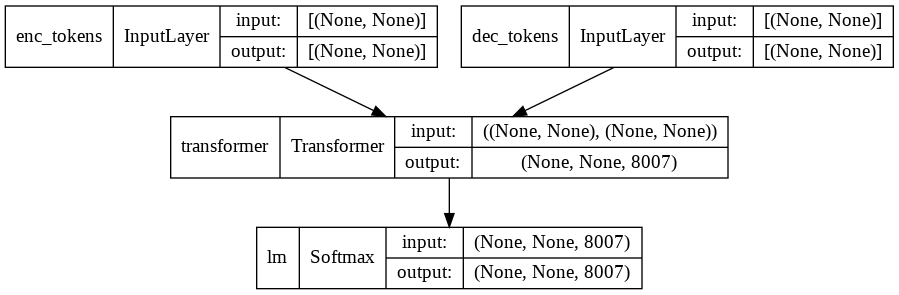

In [ ]:
model = build_model(config)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## Loss

### Tutorial

In [ ]:
# vocab 개수
n_test_vocab = 4
# 문자열 개수
n_test_seq = 8

# 정답
y_true = np.random.randint(0, n_test_vocab, (1, n_test_seq))
y_true[:,n_test_seq - 2:] = 0
y_true

array([[3, 0, 3, 1, 2, 3, 0, 0]])

In [ ]:
# 예측 값
y_pred = np.random.random((1, n_test_seq, n_test_vocab))
y_pred = tf.nn.softmax(y_pred, axis=-1)  # 확률 값으로 변경
y_pred

<tf.Tensor: shape=(1, 8, 4), dtype=float64, numpy=
array([[[0.25100796, 0.29038113, 0.19352738, 0.26508353],
        [0.156816  , 0.34132925, 0.29911483, 0.20273992],
        [0.13582323, 0.32769097, 0.29060293, 0.24588287],
        [0.17807239, 0.19304151, 0.27926074, 0.34962536],
        [0.3500575 , 0.24878816, 0.2201442 , 0.18101014],
        [0.13758752, 0.2658076 , 0.34122989, 0.25537499],
        [0.29718426, 0.2201506 , 0.28483235, 0.19783279],
        [0.25733929, 0.17902035, 0.17726573, 0.38637464]]])>

In [ ]:
# loss 계산
loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
loss

<tf.Tensor: shape=(1, 8), dtype=float64, numpy=
array([[1.32771027, 1.85268211, 1.40289998, 1.64485002, 1.51347256,
        1.3650223 , 1.21340287, 1.35735989]])>

In [ ]:
# true token이 0인 부분은 0, 아닌 부분은 1인 mask 생성
mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
mask

<tf.Tensor: shape=(1, 8), dtype=float64, numpy=array([[1., 0., 1., 1., 1., 1., 0., 0.]])>

In [ ]:
# loss에 mask를 취함. mask가 0인 부분은 모두 0
loss *= mask
loss

<tf.Tensor: shape=(1, 8), dtype=float64, numpy=
array([[1.32771027, 0.        , 1.40289998, 1.64485002, 1.51347256,
        1.3650223 , 0.        , 0.        ]])>

### 함수

In [ ]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss

### Test

In [ ]:
# loss 함수 기능 확인
loss2 = lm_loss(y_true, y_pred)
assert np.array_equal(loss, loss2)
loss2

<tf.Tensor: shape=(1, 8), dtype=float64, numpy=
array([[1.32771027, 0.        , 1.40289998, 1.64485002, 1.51347256,
        1.3650223 , 0.        , 0.        ]])>

## Accuracy

### Tutorial

In [ ]:
# vocab 개수
n_test_vocab = 3
# 문자열 개수
n_test_seq = 16

# 정답
y_true = np.random.randint(0, n_test_vocab, (1, n_test_seq))
y_true[:,n_test_seq - 2:] = 0
y_true

array([[0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 0, 0, 1, 0, 0]])

In [ ]:
# 예측 값
y_pred = np.random.random((1, n_test_seq, n_test_vocab))
y_pred = tf.nn.softmax(y_pred, axis=-1)  # 확률 값으로 변경
y_pred

<tf.Tensor: shape=(1, 16, 3), dtype=float64, numpy=
array([[[0.42962916, 0.20050436, 0.36986648],
        [0.33637154, 0.31709933, 0.34652913],
        [0.31573923, 0.47484686, 0.20941391],
        [0.25999641, 0.45710555, 0.28289804],
        [0.49895507, 0.26704405, 0.23400088],
        [0.2431871 , 0.38622575, 0.37058715],
        [0.3297653 , 0.36277189, 0.30746282],
        [0.37566364, 0.30902627, 0.31531009],
        [0.38077417, 0.33740447, 0.28182136],
        [0.34309708, 0.29835482, 0.35854811],
        [0.47506772, 0.26487238, 0.2600599 ],
        [0.24959169, 0.32607041, 0.42433791],
        [0.36358922, 0.32441693, 0.31199385],
        [0.5126483 , 0.22688291, 0.26046879],
        [0.33714714, 0.1927852 , 0.47006767],
        [0.48391873, 0.31784703, 0.19823424]]])>

In [ ]:
# 예측 값 중 최대인 index번호를 vocab으로 예측
y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
y_pred_class

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0., 2., 1., 1., 0., 1., 1., 0., 0., 2., 0., 2., 0., 0., 2., 0.]],
      dtype=float32)>

In [ ]:
# 두 값이 같으면 정답(1), 다르면 오류(0)
matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
matches

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.]],
      dtype=float32)>

In [ ]:
# true token이 0인 부분은 0, 아닌 부분은 1인 mask 생성
mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
mask

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.]],
      dtype=float32)>

In [ ]:
# matches에 mask를 취함. mask가 0인 부분은 모두 0
matches *= mask
matches

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# matches합을 mask합으로 나누면 정확도 / mask가 모두 0일 경우를 대비해서 분모에 K.maximum(K.sum(mask), 1) 사용
accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.33333334>

### 함수

In [ ]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

### Test

In [ ]:
accuracy2 = lm_acc(y_true, y_pred)
assert accuracy == accuracy2
accuracy2

<tf.Tensor: shape=(), dtype=float32, numpy=0.33333334>

## Scheduler

![](https://paul-hyun.github.io/assets/transformer/learning_rate.png)

### Tutorial

In [ ]:
warmup_steps = tf.dtypes.cast(1000, tf.float32)
step_num = tf.dtypes.cast(1100, tf.float32)
d_model = tf.dtypes.cast(config.d_model, tf.float32)

warmup_steps, step_num, d_model

(<tf.Tensor: shape=(), dtype=float32, numpy=1000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1100.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=256.0>)

In [ ]:
# step_num ** -0.5 (https://www.tensorflow.org/api_docs/python/tf/math/rsqrt)
arg1 = tf.math.rsqrt(step_num)
arg1

<tf.Tensor: shape=(), dtype=float32, numpy=0.030151132>

In [ ]:
# step_num * (warmup_steps ** -1.5)
arg2 = step_num * (warmup_steps ** -1.5)
arg2

<tf.Tensor: shape=(), dtype=float32, numpy=0.034785062>

In [ ]:
# 두 값중 작은 값 선택
arg = tf.math.minimum(arg1, arg2)
arg

<tf.Tensor: shape=(), dtype=float32, numpy=0.030151132>

In [ ]:
# (d_model ** -0.5) * arg
lr = tf.math.rsqrt(d_model) * arg
lr

<tf.Tensor: shape=(), dtype=float32, numpy=0.0018844458>

### Class

In [ ]:
class InverseSquareRootSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    TransformerSchedule class
    """
    def __init__(self, d_model, warmup_steps=4000):
        """
        생성자
        :param d_model: 모델 hidden
        :param warmup_steps: warmup steps
        """
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        arg1 = tf.math.rsqrt(step_num)
        arg2 = step_num * (self.warmup_steps**-1.5)
        arg = tf.math.minimum(arg1, arg2)
        lr = tf.math.rsqrt(self.d_model) * arg
        return lr

### Test

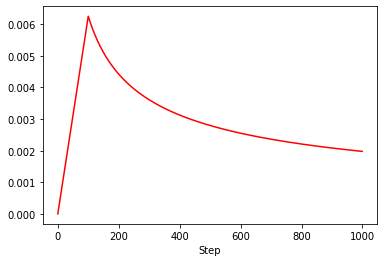

In [ ]:
# compute lr
test_schedule = InverseSquareRootSchedule(config.d_model, warmup_steps=100)
lrs = []
for step in range(1000):
    lrs.append(test_schedule(float(step)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

## Train

In [ ]:
# optimizer의 learning_rate를 InverseSquareRootSchedule로 지정
learning_rate = InverseSquareRootSchedule(config.d_model, warmup_steps=500)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])

In [ ]:
save_path = './logs'
if not os.path.exists(save_path):
        os.makedirs(save_path)
saved_model_path = save_path +"/chat_transformer.hdf5"

# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(saved_model_path, monitor="lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = model.fit(train_inputs, train_labels, epochs=50, batch_size=256, callbacks=[save_weights])

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 1.2453 - lm_acc: 0.2992
Epoch 00001: lm_acc improved from -inf to 0.29921, saving model to ./logs/chat_transformer.hdf5
47/47 [==============================] - 17s 362ms/step - loss: 1.2453 - lm_acc: 0.2992
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 1.1849 - lm_acc: 0.3168
Epoch 00002: lm_acc improved from 0.29921 to 0.31681, saving model to ./logs/chat_transformer.hdf5
47/47 [==============================] - 17s 372ms/step - loss: 1.1849 - lm_acc: 0.3168
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 1.1091 - lm_acc: 0.3369
Epoch 00003: lm_acc improved from 0.31681 to 0.33690, saving model to ./logs/chat_transformer.hdf5
47/47 [==============================] - 17s 365ms/step - loss: 1.1091 - lm_acc: 0.3369
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.9933 - lm_acc: 0.3717
Epoch 00004: lm_acc improved from 0.33690 to 0.37169, saving model to ./lo

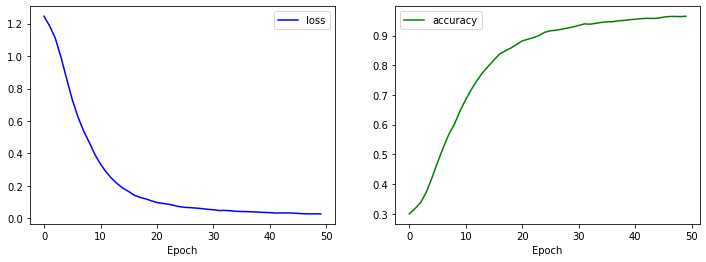

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

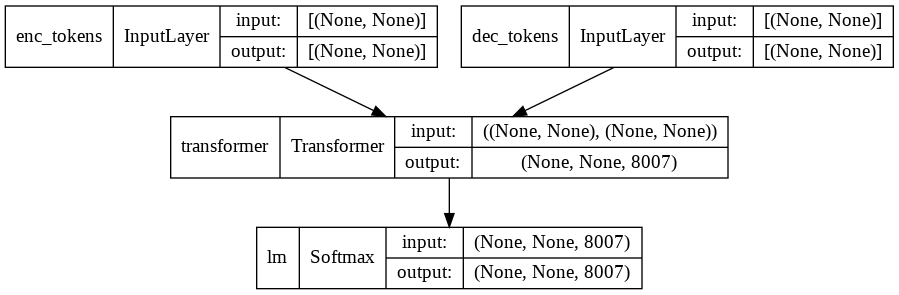

In [ ]:
model = build_model(config)
tf.keras.utils.plot_model(model, 'transformer_model.png', show_shapes=True)

In [ ]:
# 기존 학습 weight 로드
model.load_weights(saved_model_path)

In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 디코더 입력 개수
    :param string: 입력 문자열
    """
    # enc_token 생성: <string tokens>, [PAD] tokens
    enc_token = vocab.encode_as_ids(string)
    # dec_token 생성: [BOS], [PAD] tokens
    dec_token = [vocab.bos_id()]
    dec_token += [0] * (n_seq - len(dec_token))
    dec_token = dec_token[:n_seq]

    response = []
    for i in range(n_seq - 1):
        # model 실행
        output = model.predict((np.array([enc_token]), np.array([dec_token])))
        # decoder의 마지막 위치의 token 예측 값
        word_id = int(np.argmax(output, axis=2)[0][i])
        # [EOS] 토큰이 생성되면 종료
        if word_id == vocab.eos_id():
            break
        # 예측된 token을 응답에 저장
        response.append(word_id)
        # 예측된 token을 decoder의 다음 입력으로 저장
        dec_token[i + 1] = word_id
    
    # 생성된 token을 문자열로 변경
    return vocab.decode_ids(response)

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, 20, string)}")

input > 오늘 수업이 어려운 것 같아.
output > 다른 곳에 관심이 많은가봐요.
input > 조금 우울해
output > 바뀌니의 몫이에요.
input > 저녁은 무엇을 먹을까?
output > 맛있는 거 드세요.
input > 크리스마스에 여행가고 싶다.
output > 바쁘게 사나봅니다.
input > 3박4일 정도 놀러가고 싶다.
output > 여행은 언제나 좋죠.
input > 
